In [ ]:
import sys
import time
import matplotlib.pyplot as plt # https://matplotlib.org/
import numpy as np # http://www.numpy.org/
import tekwfm
import os
from os.path import exists
from scipy import signal
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.special import gamma
import matplotlib.cm as cm
from collections import Counter
from scipy.signal import find_peaks

import gc
import re
import tempfile
from collections import defaultdict, namedtuple
from pathlib import Path
import pandas as pd

In [ ]:
doVerbose = False

#import the wfm file
filename_base = "PMT4_rawdata/220126_darkrate_1750_10000_1_on"


#saving the processed file
folder_name = "PMT4_AllAnalysis/PMT4Processed/2000"
file_name = "200126_darkrate_2000_10000_1_off_processed.csv" 
file_path = os.path.join(os.getcwd(), folder_name, file_name)


startEvent = 100
nEvents = 100

# code here to pass arguments

volts, tstart, tscale, tfrac, tdatefrac, tdate = tekwfm.read_wfm(filename_base+".wfm")
if doVerbose:
    print('>>>>', volts, tstart, tscale, tfrac, tdatefrac, tdate)

samples = volts.shape

print(len(volts))
print(tscale)
print('samples', samples[0])
tstop = samples[0]*tscale+tstart
sampleTimes = [tstart+x*tscale for x in range(samples[0])]


negVolts = [volts[:, event] for event in range(startEvent, startEvent + nEvents)] # all events, array of array of voltages
#tempVolts = -1 * negVolts # makes pulses positive
tempVolts = [-v for v in negVolts]

'''
for event in range(startEvent, startEvent+nEvents+1):
    tempVolt = volts[:,event]
    plt.figure(figsize=(6, 6))
    plt.plot(np.array(sampleTimes)*1e9,np.array(tempVolt)*1e3, color='black')
    plt.tick_params(axis='both', labelsize=12)
    plt.xlabel('Oscilloscope Timebase (ns)', fontsize=14)
    plt.xlim(-20,80)
    plt.ylabel('Voltage (mV)', fontsize=14)
    #plt.ylim(-25, 2)
    plt.show()
    del(tempVolt)
'''

1250
8e-11
samples 1250


"\nfor event in range(startEvent, startEvent+nEvents+1):\n    tempVolt = volts[:,event]\n    plt.figure(figsize=(6, 6))\n    plt.plot(np.array(sampleTimes)*1e9,np.array(tempVolt)*1e3, color='black')\n    plt.tick_params(axis='both', labelsize=12)\n    plt.xlabel('Oscilloscope Timebase (ns)', fontsize=14)\n    plt.xlim(-20,80)\n    plt.ylabel('Voltage (mV)', fontsize=14)\n    #plt.ylim(-25, 2)\n    plt.show()\n    del(tempVolt)\n"

In [ ]:
#to see 1 pulse
#make sure you change startEvent and nEvents
"""
for event in range(startEvent, startEvent+nEvents+1):
    tempVolt = volts[:,event]
    plt.plot(sampleTimes,tempVolt)
    plt.show()
    del(tempVolt)
"""


'\nfor event in range(startEvent, startEvent+nEvents+1):\n    tempVolt = volts[:,event]\n    plt.plot(sampleTimes,tempVolt)\n    plt.show()\n    del(tempVolt)\n'

In [ ]:
"""variables which can be changed"""
baseline_end_frac = 0.15
amplitude_start_frac = 0
amplitude_end_frac = 0.6
pulse_end_frac = 0.99

timediffbins=1000 #number of bins in the histogram for time between each event
zoomedtimediffbins=10000 #number of bins in the zoomed in histogram for time between each event
zoom=0.0005 #the max x coordinate for zooming in on this histogram (looking at range 0 to 0.0005)


In [ ]:
def calcbaseline(tempVolt, samples):
    baseline_voltages = tempVolt[0: int(baseline_end_frac*samples[0])]
    mean_b = np.mean(baseline_voltages)
    sigma_b = np.std(baseline_voltages, ddof=1)
    correct_tempVolt = tempVolt - mean_b
    return mean_b, sigma_b, correct_tempVolt

def calcamplitude(corrected_tempVolt, samples, sigma_b):
    #amplitude_voltages = corrected_tempVolt[int(amplitude_start_frac*samples[0]):int(amplitude_end_frac*samples[0])]
    threshold = 3 * sigma_b
    if threshold > 0.003:
        min_height = 3 * sigma_b
    else:
        min_height = 0.003
    min_separation = int(0.05*samples[0])
    prominance = 0.005
    #peaks, _ = find_peaks(amplitude_voltages, height=min_height, distance=min_separation, prominence=prominance)
    peaks, properties = find_peaks(corrected_tempVolt, height=min_height, distance=min_separation, prominence=prominance)
    number_of_peaks = len(peaks)
    if len(peaks) > 0:
        #amplitude = amplitude_voltages[peaks[0]]
        amplitude = corrected_tempVolt[peaks[0]]
        #first_peak_index = peaks[0] + int(amplitude_start_frac*samples[0])
        first_peak_index = peaks[0]
        first_peak_time = sampleTimes[first_peak_index]
    else:
        #amplitude = np.max(amplitude_voltages)
        amplitude = np.max(corrected_tempVolt)
        amp_index = np.argmax(corrected_tempVolt)
        #amp_index = np.argmax(amplitude_voltages)
        #first_peak_index = amp_index + int(amplitude_start_frac*samples[0])
        first_peak_index = amp_index
        first_peak_time = sampleTimes[first_peak_index]
    if amplitude > 0.22:
       number_of_peaks = 1

    return amplitude, first_peak_index, first_peak_time, number_of_peaks

def peak_FWHM(corrected_tempVolt, amplitude, first_peak_index, sampleTimes):   
    half_maximum = amplitude/2
    
    #left crossing of half maximum
    left = first_peak_index #begin at index of peak
    #move left until voltage rises to half maximum, stopping if left>0 (beginning of window reached)
    while left>0 and corrected_tempVolt[left]>half_maximum:
        left -= 1 #index moves left
    #interpolate between left and left+1
    if left == 0: #if beginning of window reached, take first time value as left crossing
        left_time = sampleTimes[0]
    else: 
        y1, y2 = corrected_tempVolt[left], corrected_tempVolt[left+1]
        x1, x2 = sampleTimes[left], sampleTimes[left+1]
        left_time = x1 + (half_maximum - y1)/(y2-y1) * (x2-x1)
        
    #same again for right
    right = first_peak_index
    while right<len(corrected_tempVolt)-1 and corrected_tempVolt[right]>half_maximum:
        right += 1
    #interpolate between right and right-1
    if right == len(corrected_tempVolt)-1: #if end of window reached, take last time value as right crossing
        right_time = sampleTimes[-1]
    else: 
        y1, y2 = corrected_tempVolt[right], corrected_tempVolt[right-1]
        x1, x2 = sampleTimes[right], sampleTimes[right-1]
        right_time = x1 + (half_maximum - y1)/(y2-y1) * (x2-x1)
    
    singleFWHM = right_time - left_time
    return singleFWHM, left_time, right_time
'''
def time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b, first_peak_index):
    threshold_voltage = 11*sigma_b 
    
    #first crossing of threshold
    first = first_peak_index #begin at index of peak
    
    #move left until voltage rises to threshold, stopping if first>0 (beginning of window reached)
    while first>0 and corrected_tempVolt[first]>threshold_voltage:
        first -= 1 #index moves left
    #interpolate between first and first+1
    if first == 0 and corrected_tempVolt[first]>threshold_voltage: #if beginning of window reached, take no crossing time
        first_cross = None
    else: 
        y1, y2 = corrected_tempVolt[first], corrected_tempVolt[first+1]
        x1, x2 = sampleTimes[first], sampleTimes[first+1]
        first_cross = x1 + (threshold_voltage - y1)/(y2-y1) * (x2-x1)
        
    #same again for right
    second = first_peak_index
    while second<len(corrected_tempVolt)-1 and corrected_tempVolt[second]>threshold_voltage:
        second += 1
    #interpolate between second and second-1
    if second == len(corrected_tempVolt)-1 and corrected_tempVolt[first]>threshold_voltage: #if end of window reached, take no crossing time
        second_cross = None
    else: 
        y1, y2 = corrected_tempVolt[second], corrected_tempVolt[second-1]
        x1, x2 = sampleTimes[second], sampleTimes[second-1]
        second_cross = x1 + (threshold_voltage - y1)/(y2-y1) * (x2-x1)
    
    if first_cross is not None and second_cross is not None:
        time_above = second_cross - first_cross

        if time_above <= 0:
            time_above = None
            first_cross = None
            second_cross = None
    else:
        time_above = None
        first_cross = None
        second_cross = None

    return time_above, first_cross, second_cross

'''
def time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b, mean_b):
    threshold = 11 * sigma_b

    time_above = 0.0
    first_cross = None
    second_cross = None

    above = False  # are we currently above threshold?

    for i in range(len(corrected_tempVolt) - 1):
        v1 = corrected_tempVolt[i]
        v2 = corrected_tempVolt[i + 1]
        t1 = sampleTimes[i]
        t2 = sampleTimes[i + 1]
        dt = t2 - t1

        # Rising crossing
        if v1 <= threshold and v2 > threshold:
            frac = (threshold - v1) / (v2 - v1)
            t_cross = t1 + frac * dt

            if first_cross is None:
                first_cross = t_cross

            above = True
            time_above += (1 - frac) * dt

        # Falling crossing
        elif v1 > threshold and v2 <= threshold:
            frac = (threshold - v1) / (v2 - v1)
            t_cross = t1 + frac * dt

            if above:
                second_cross = t_cross
                time_above += frac * dt
                above = False

        # Entire segment above threshold
        elif v1 > threshold and v2 > threshold:
            time_above += dt

    # If we never formed a complete rise–fall pair, reject
    if first_cross is None or second_cross is None or time_above <= 0:
        return None, None, None
    if max(corrected_tempVolt) <= threshold:
        return None, None, None

    return time_above, first_cross, second_cross

'''
#threshold passed as an argument, n
def time_above_threshold(corrected, times, sigma_b, first_peak_index):
    threshold = 11*sigma_b

    i = first_peak_index
    while i > 0 and corrected[i] > threshold:
        i -= 1
    # If we hit the boundary and are STILL above threshold → no crossing
    if i == 0 and corrected[i] > threshold:
        return None, None, None
    if i == len(corrected) - 1:
        # This implies the peak is at the very end, and the left search stopped
        # right at the end of the array, meaning we can't interpolate i to i+1.
        return None, None, None
    # Interpolate only if we actually crossed between i and i+1
    y1, y2 = corrected[i], corrected[i+1]
    x1, x2 = times[i], times[i+1]
    # Ensure interpolation makes physical sense
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):  
        return None, None, None
    first_cross = x1 + frac * (x2 - x1)

    j = first_peak_index
    while j < len(corrected)-1 and corrected[j] > threshold:
        j += 1
    if j == len(corrected)-1 and corrected[j] > threshold:
        return None, None, None
    y1, y2 = corrected[j-1], corrected[j]
    x1, x2 = times[j-1], times[j]
    if (y2 - y1) == 0:
        return None, None, None
    frac = (threshold - y1) / (y2 - y1)
    if not (0 <= frac <= 1):
        return None, None, None
    second_cross = x1 + frac * (x2 - x1)

    time_above = second_cross - first_cross
    if time_above <= 0:
        return None, None, None

    return time_above, first_cross, second_cross
'''
def total_time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b):
    threshold = 11 * sigma_b
    if max(corrected_tempVolt) <= threshold:
        return None
    total_time = 0.0

    for i in range(len(corrected_tempVolt) - 1):
        v1 = corrected_tempVolt[i]
        v2 = corrected_tempVolt[i + 1]
        t1 = sampleTimes[i]
        t2 = sampleTimes[i + 1]
        dt = t2 - t1

        # Entire segment above threshold
        if v1 > threshold and v2 > threshold:
            total_time += dt

        # Rising through threshold
        elif v1 <= threshold and v2 > threshold:
            frac = (threshold - v1) / (v2 - v1)
            total_time += (1 - frac) * dt

        # Falling through threshold
        elif v1 > threshold and v2 <= threshold:
            frac = (threshold - v1) / (v2 - v1)
            total_time += frac * dt

        # Else: fully below threshold → add nothing

    return total_time if total_time > 0 else None

#convert first crossing time to index to be used in integral
def time_index(first_cross, sampleTimes):
    if first_cross is None:
        return len(sampleTimes) - 1
    else:
        time_difference = np.abs(np.array(sampleTimes) - first_cross)
        closest_index = np.argmin(time_difference)
        return closest_index



#integrate a single event
def single_charge_integral(corrected_tempVolt, sampleTimes, closest_index):
    # define bound 1 and 2
    bound_1 = closest_index
    bound_2 = int(pulse_end_frac*len(corrected_tempVolt))
    integral_voltages = corrected_tempVolt[bound_1:bound_2]
    time_slice = sampleTimes[bound_1:bound_2]
    single_integral = integrate.trapezoid(integral_voltages, x=time_slice)
    #return a single number for the integral of one event
    return single_integral

def correcting_tempVolts(tempVolts, mean_b):
    corrected_tempVolts = []
    for i, tempVolt in enumerate(tempVolts):
        corrected = tempVolt - mean_b[i]
        corrected_tempVolts.append(corrected)
    return corrected_tempVolts

In [ ]:
"""Working on all events"""
mean_b_array = []
sigma_b_array = []
corrected_tempVolts = []
all_amplitudes = []
all_peak_times = []
all_peak_indices = []
all_FWHM = []
all_t1 = []
all_t2 = []
all_time_above_thresh = []
all_total_time_above = []
all_first_crossing = []
all_second_crossing = []
all_closest_indices = []
all_integrals = []

for tempVolt in tempVolts:
    mean_b, sigma_b, corrected_tempVolt = calcbaseline(tempVolt, samples)
    mean_b_array.append(mean_b)
    sigma_b_array.append(sigma_b)
    corrected_tempVolts.append(corrected_tempVolt)

mean_b_array = np.array(mean_b_array)
sigma_b_array = np.array(sigma_b_array)
corrected_tempVolts = np.array(corrected_tempVolts)



time_above: 7.222829726471476e-10
total_time_above 7.222829726471476e-10
first_crossing_time: -8.218346116362179e-11
second_crossing_time: 7.078259719632088e-10
11 sig thresh 0.005038970066423945
amplitude: 0.005969230447860967


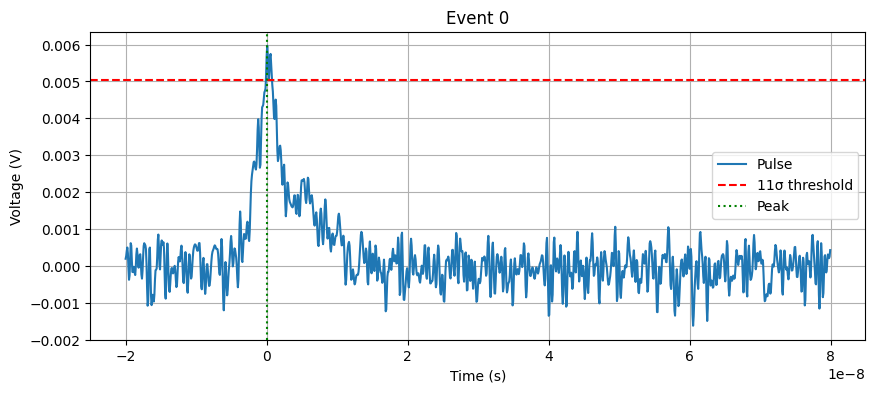

time_above: 6.176490215954014e-08
total_time_above 6.176490215954014e-08
first_crossing_time: -6.454572732205747e-10
second_crossing_time: 7.132636396109768e-08
11 sig thresh 0.012863938273931307
amplitude: 0.22155738218582888


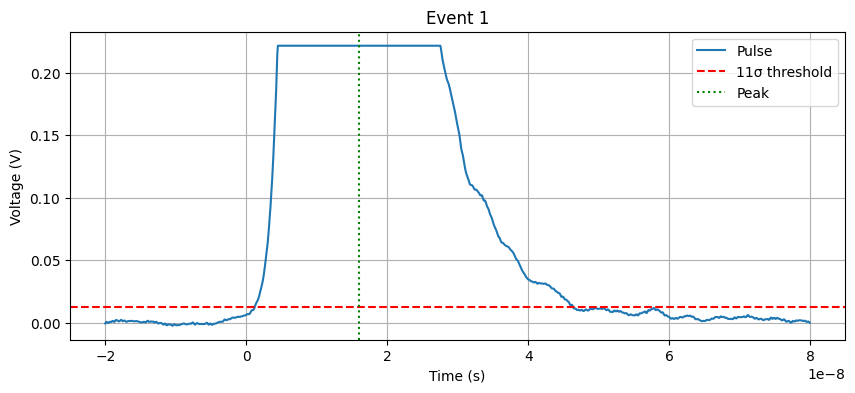

time_above: 9.866626994144577e-09
total_time_above 9.866626994144577e-09
first_crossing_time: -5.151213459231673e-10
second_crossing_time: 4.128379372088038e-08
11 sig thresh 0.007162098904977231
amplitude: 0.005541569184491977


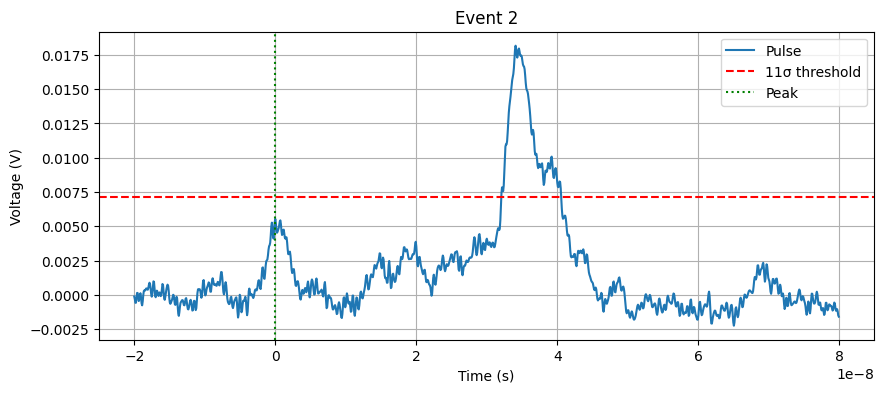

time_above: 1.401484570386906e-09
total_time_above 1.401484570386906e-09
first_crossing_time: -1.2541021779895966e-10
second_crossing_time: 1.2760743525879463e-09
11 sig thresh 0.004543280289174669
amplitude: 0.006887867647058825


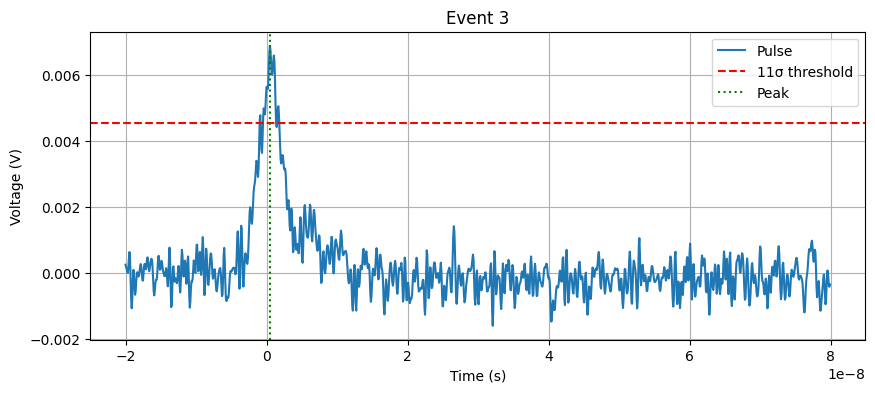

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.005012920848290195
amplitude: 0.005012721423796792


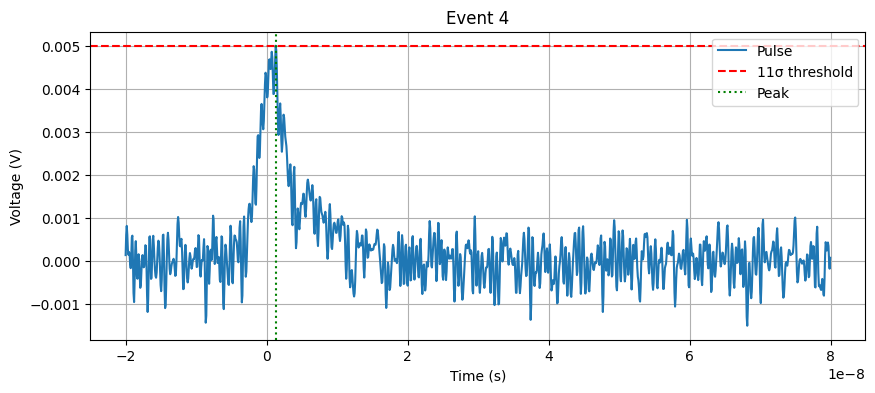

time_above: 6.899442744008428e-09
total_time_above 6.899442744008428e-09
first_crossing_time: 5.294446762404251e-10
second_crossing_time: 8.938084386628724e-09
11 sig thresh 0.013064801464104112
amplitude: 0.0076806901737967994


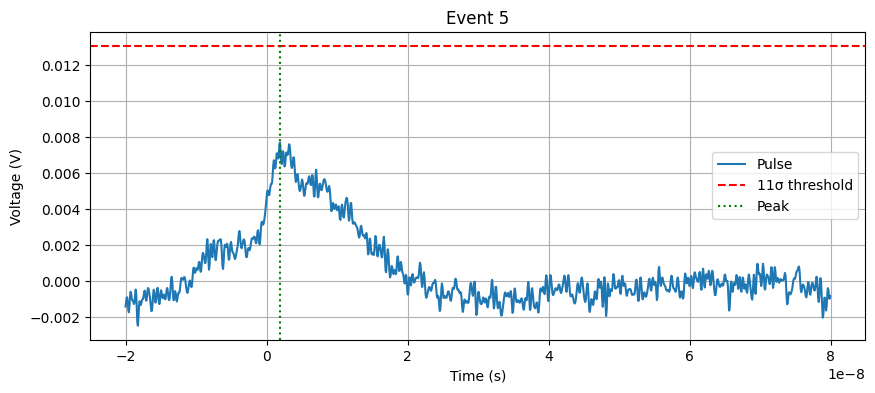

time_above: 1.7790744474249516e-10
total_time_above 1.7790744474249516e-10
first_crossing_time: -5.56914503265757e-11
second_crossing_time: 1.2221599441591946e-10
11 sig thresh 0.005443362781694515
amplitude: 0.005494861296791438


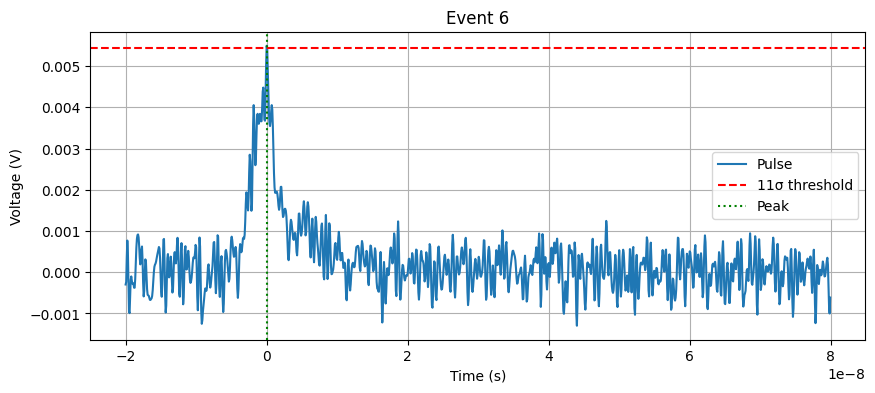

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.005172856589990633
amplitude: 0.004803183489304816


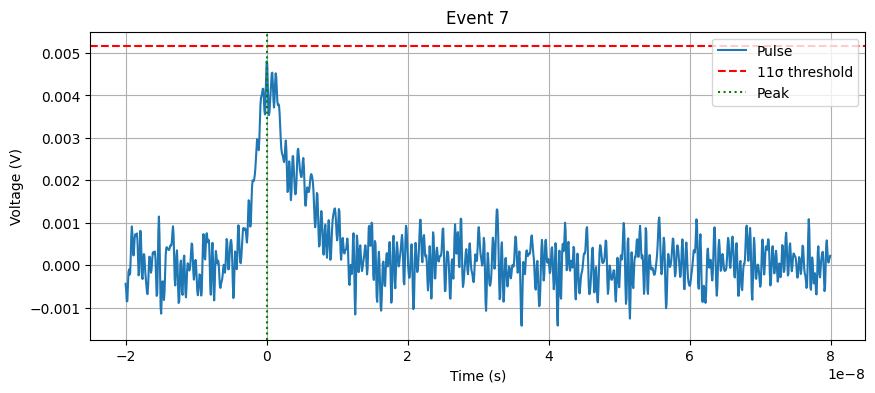

time_above: 2.2573053918231188e-09
total_time_above 2.2573053918231188e-09
first_crossing_time: -1.1875728466562678e-10
second_crossing_time: 2.1385481071574917e-09
11 sig thresh 0.004422489855523154
amplitude: 0.006492459057486635


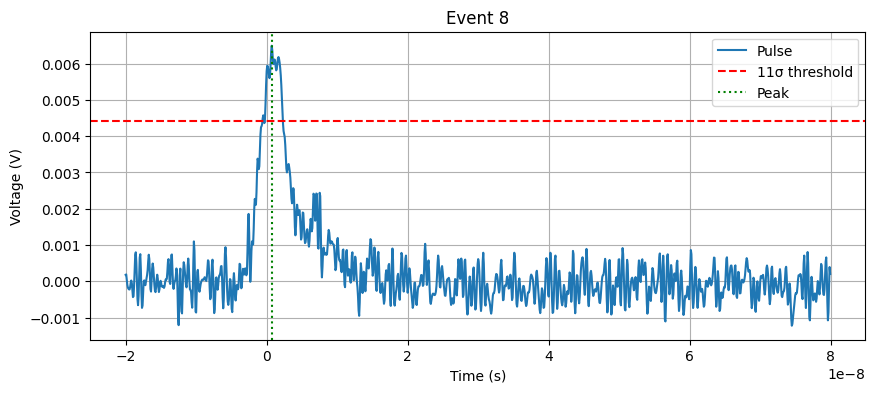

time_above: 1.1610269656427967e-10
total_time_above 1.1610269656427967e-10
first_crossing_time: -2.2733143882592285e-11
second_crossing_time: 9.336955268168738e-11
11 sig thresh 0.008213679250404303
amplitude: 0.00544577205882353


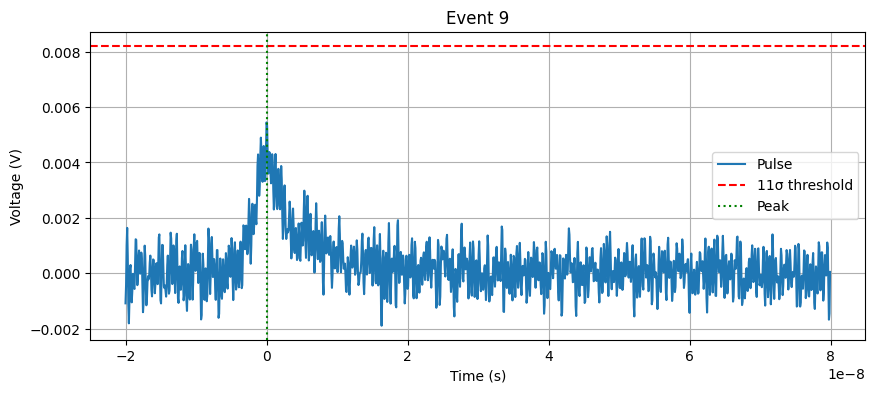

time_above: 1.386721983639495e-10
total_time_above 1.386721983639495e-10
first_crossing_time: 8.262078742082244e-10
second_crossing_time: 9.64880072572174e-10
11 sig thresh 0.004443585139822411
amplitude: 0.00531254177807486


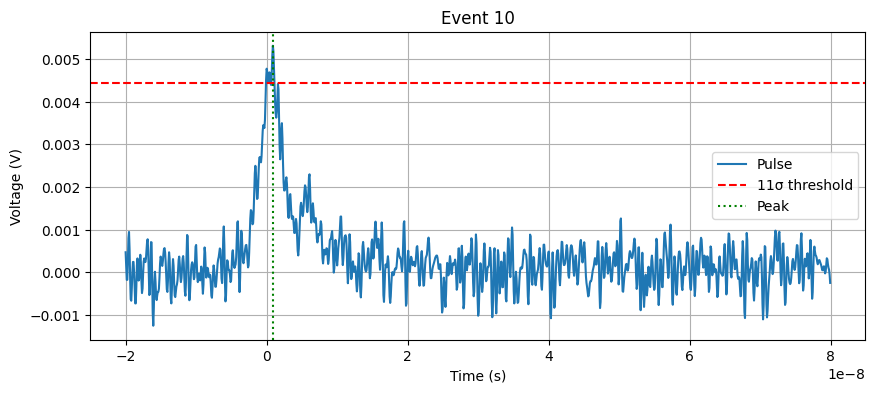

time_above: 2.3883960105247923e-10
total_time_above 2.3883960105247923e-10
first_crossing_time: -5.873197398282241e-11
second_crossing_time: 1.8010762706965685e-10
11 sig thresh 0.0069718311670664045
amplitude: 0.006034028241978612


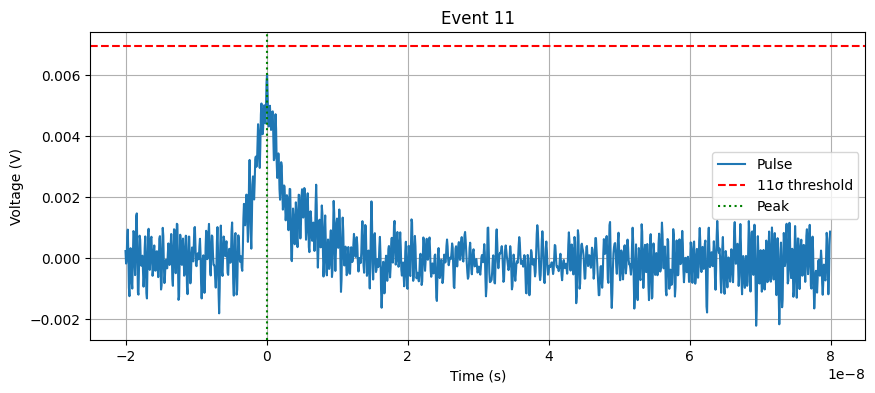

time_above: 3.2452473187442255e-09
total_time_above 3.2452473187442255e-09
first_crossing_time: -5.462069282371143e-11
second_crossing_time: 3.1906266259205142e-09
11 sig thresh 0.004679812389612412
amplitude: 0.008229570521390376


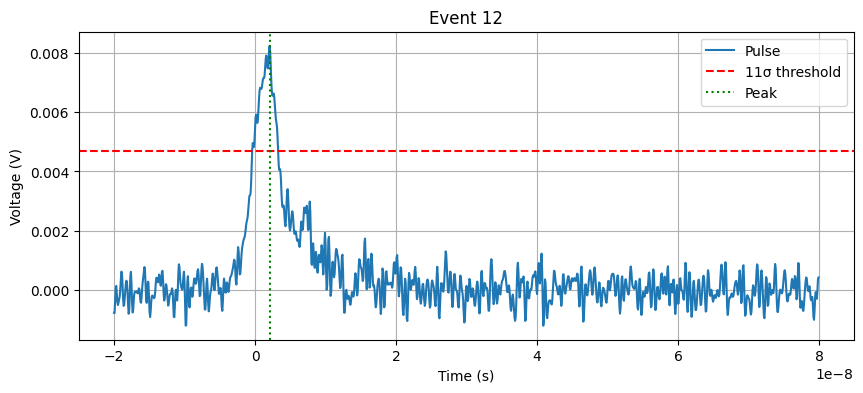

time_above: 1.5588805347625573e-09
total_time_above 1.5588805347625573e-09
first_crossing_time: -4.329568903305307e-11
second_crossing_time: 2.1432926874878257e-09
11 sig thresh 0.00528904693646475
amplitude: 0.0062755055147058775


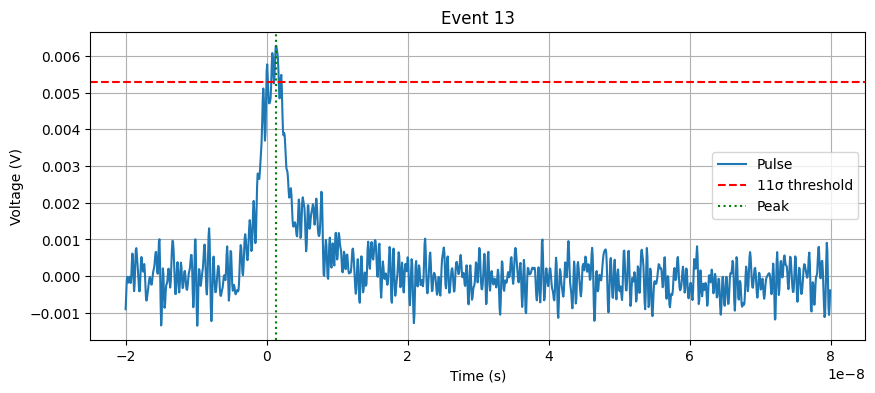

time_above: 5.950724716022345e-10
total_time_above 5.950724716022345e-10
first_crossing_time: -5.537881603876186e-10
second_crossing_time: 3.56971800979253e-10
11 sig thresh 0.0050696225704227795
amplitude: 0.00624726353609626


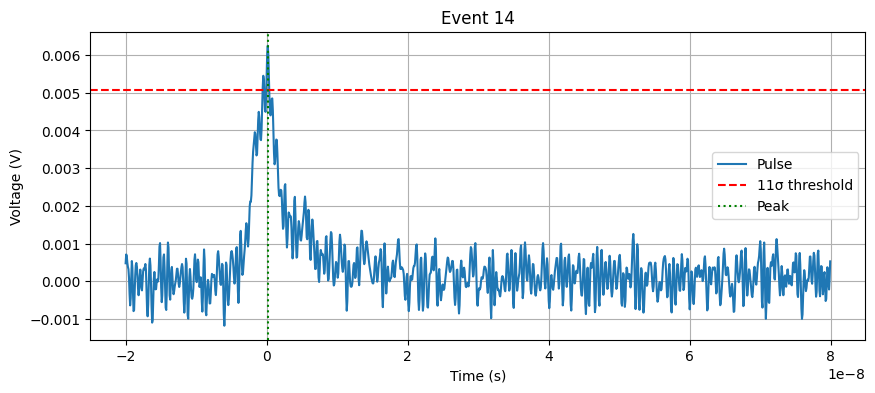

time_above: 9.140198497190378e-10
total_time_above 9.140198497190378e-10
first_crossing_time: -1.1434894204612077e-10
second_crossing_time: 1.055580144129044e-09
11 sig thresh 0.004484369002840289
amplitude: 0.0065614137700534805


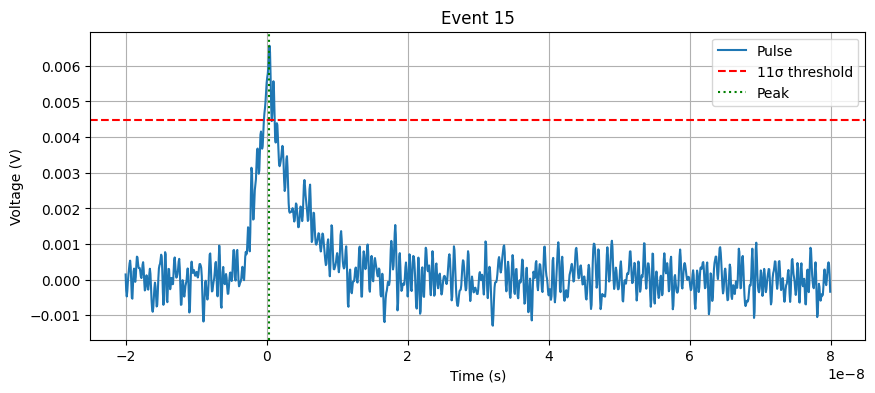

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.0044578976939932515
amplitude: 0.0049628384024064135


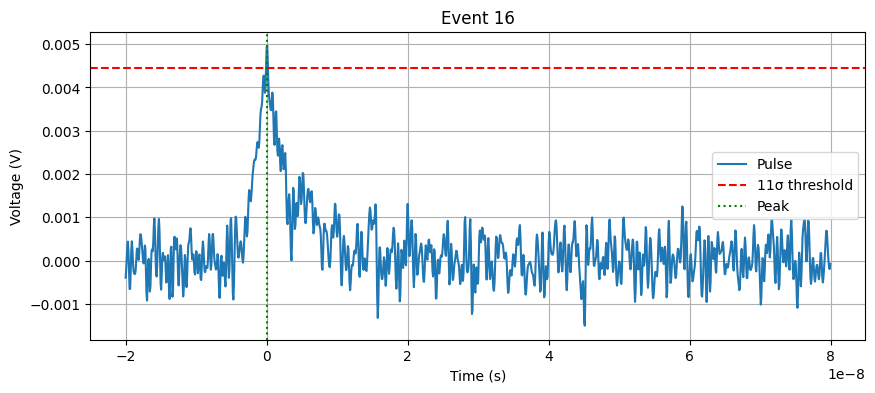

time_above: 1.621590855641854e-08
total_time_above 1.621590855641854e-08
first_crossing_time: -1.9072157520978428e-09
second_crossing_time: 1.516654397074677e-08
11 sig thresh 0.009520991583795777
amplitude: 0.011605009191176466


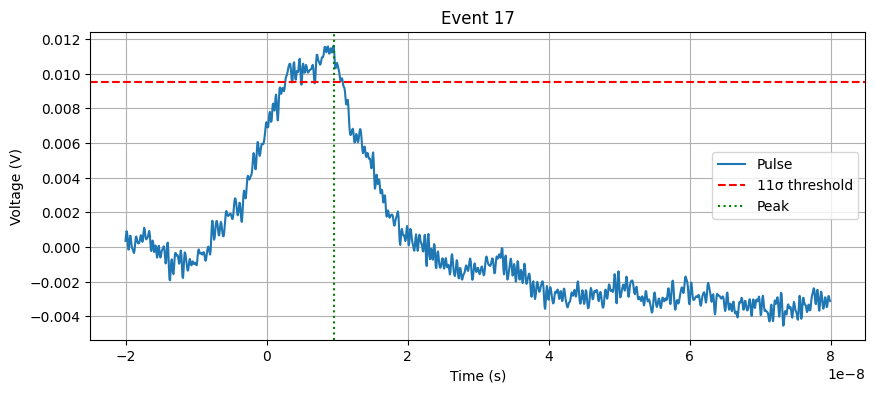

time_above: 2.673911250941344e-09
total_time_above 2.673911250941344e-09
first_crossing_time: -4.0491192224502094e-10
second_crossing_time: 2.3118042232326036e-09
11 sig thresh 0.004558642531630126
amplitude: 0.007407002005347597


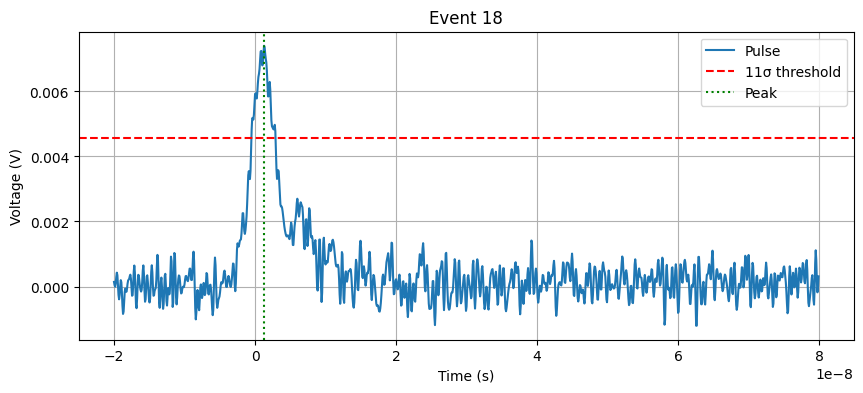

time_above: 2.092594696907512e-09
total_time_above 2.092594696907512e-09
first_crossing_time: -4.268911333268099e-10
second_crossing_time: 2.2013766209213344e-09
11 sig thresh 0.0045091489596104
amplitude: 0.006896578375668444


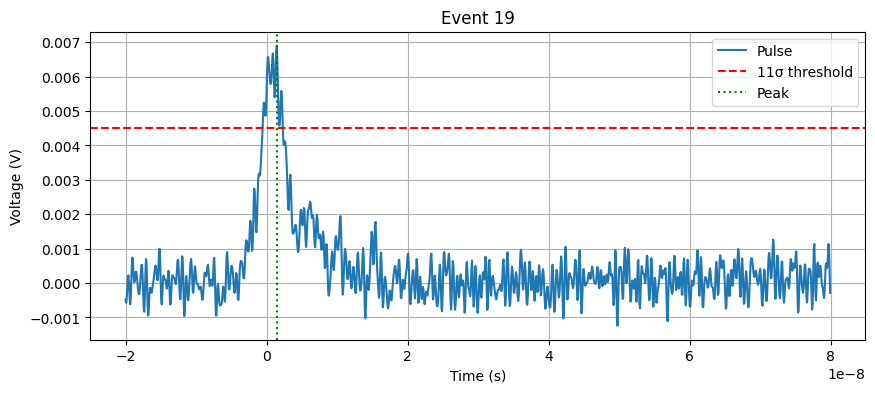

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.004631886917200184
amplitude: 0.00456922627005348


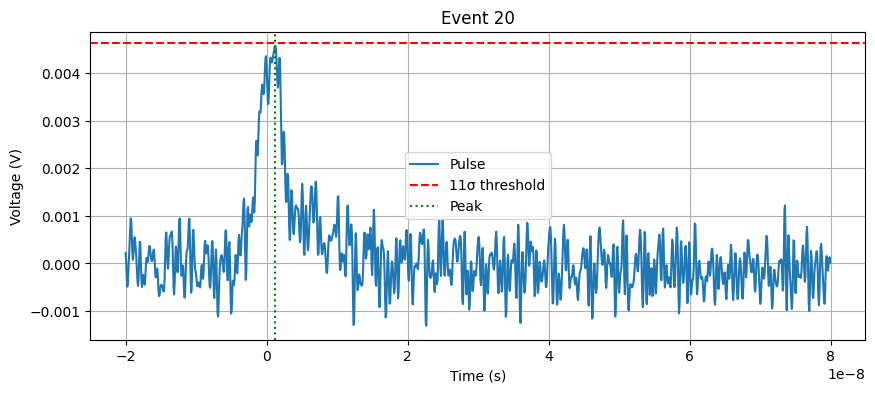

time_above: 2.0990843953943067e-10
total_time_above 2.0990843953943067e-10
first_crossing_time: -1.2035828529098278e-09
second_crossing_time: 1.1060933521743247e-10
11 sig thresh 0.006902276283752539
amplitude: 0.005604821189839568


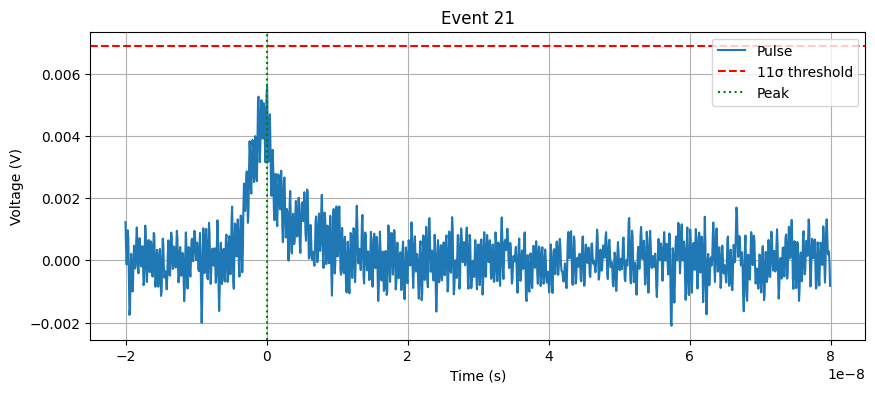

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.0044075279111926245
amplitude: 0.0044198905414438525


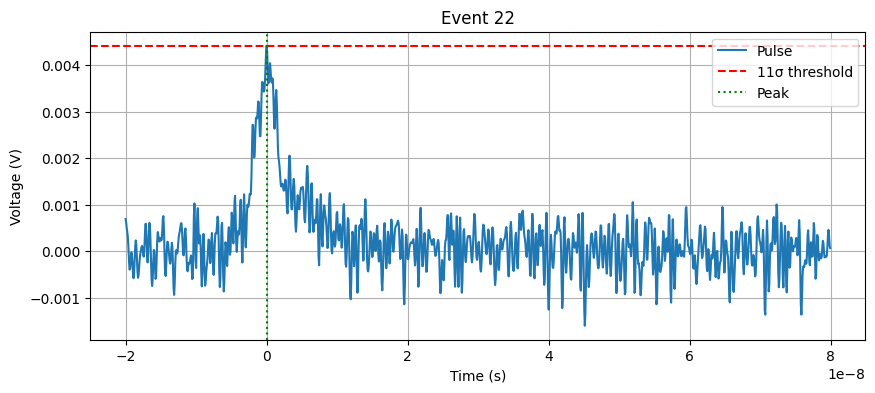

time_above: 4.984319564919636e-10
total_time_above 4.984319564919636e-10
first_crossing_time: 3.727055611835331e-10
second_crossing_time: 1.3810887120346967e-09
11 sig thresh 0.0045270136172569355
amplitude: 0.005593185995989299


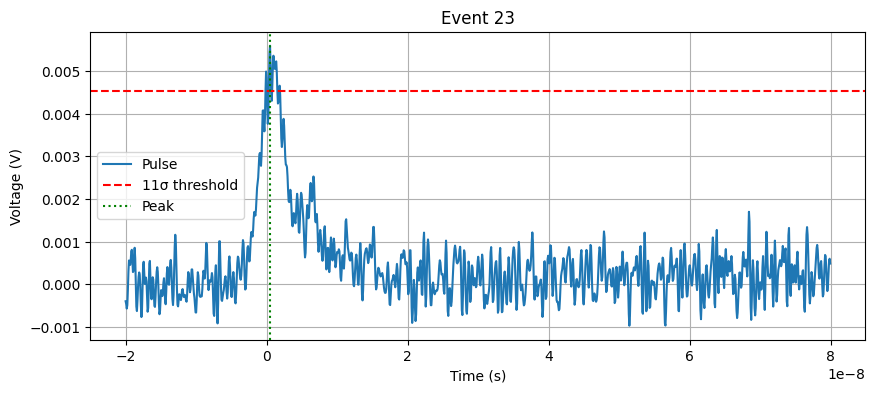

time_above: 2.2348778630896503e-09
total_time_above 2.2348778630896503e-09
first_crossing_time: -1.1205833351620086e-09
second_crossing_time: 1.1142945279276417e-09
11 sig thresh 0.004852079430382638
amplitude: 0.006961397058823529


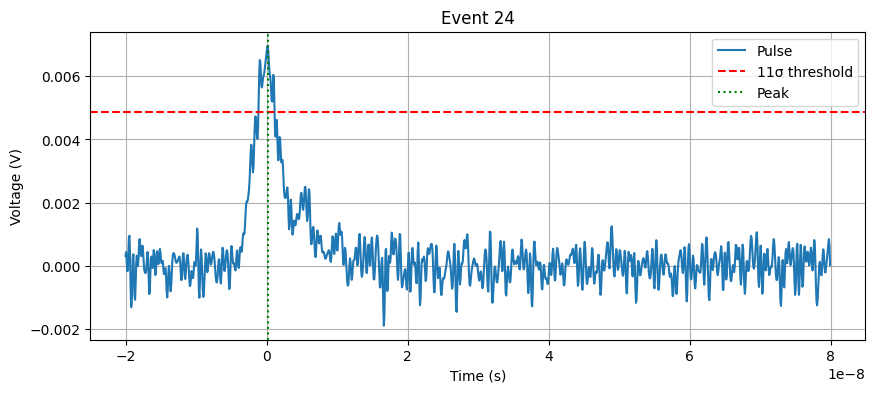

time_above: 2.8195931337692286e-09
total_time_above 2.8195931337692286e-09
first_crossing_time: -1.406523812244348e-10
second_crossing_time: 2.678940752544794e-09
11 sig thresh 0.004953776285283098
amplitude: 0.007514726771390369


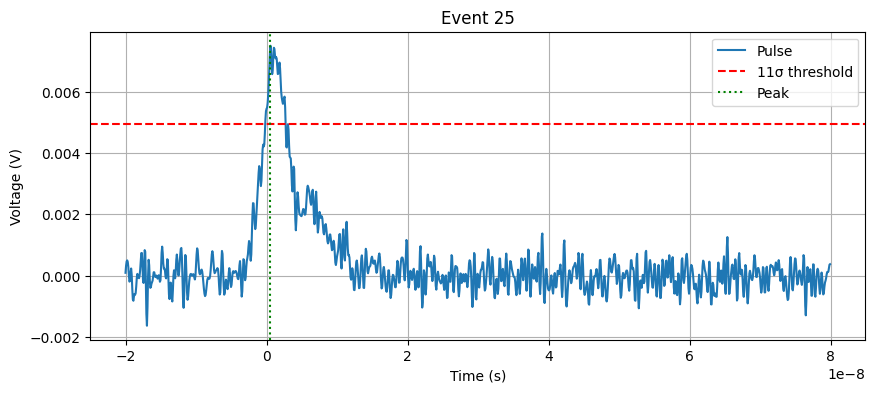

time_above: 8.30960363653911e-09
total_time_above 8.30960363653911e-09
first_crossing_time: -5.063062759936259e-10
second_crossing_time: 5.9455773063403934e-08
11 sig thresh 0.005684089599524069
amplitude: 0.007059596423796794


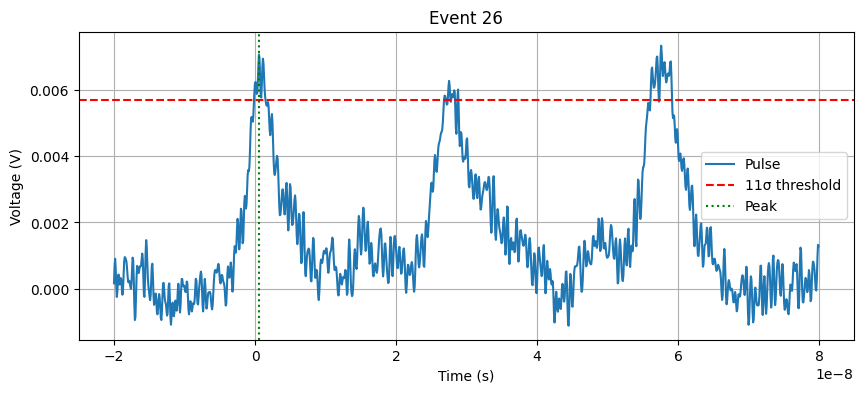

time_above: 5.0825130007518114e-08
total_time_above 5.0825130007518114e-08
first_crossing_time: -5.641907245510967e-11
second_crossing_time: 7.694040058396444e-08
11 sig thresh 0.007254898838701373
amplitude: 0.009364639037433162


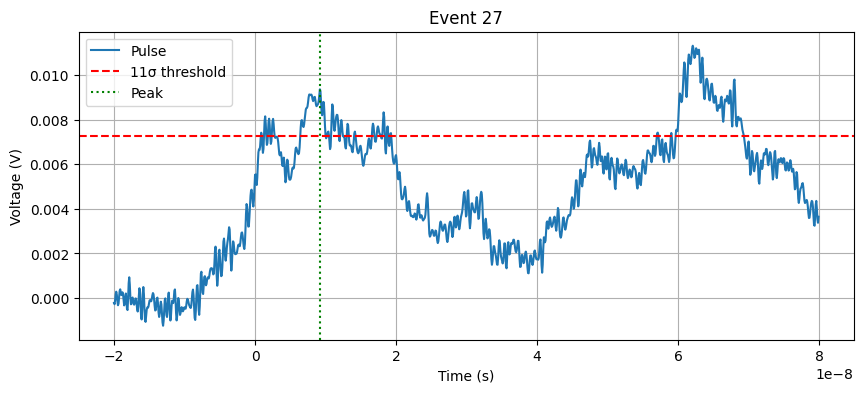

time_above: 1.6752682796420003e-09
total_time_above 1.6752682796420003e-09
first_crossing_time: -7.675934001173092e-11
second_crossing_time: 1.996366837886691e-09
11 sig thresh 0.004105230368949439
amplitude: 0.006115370153743322


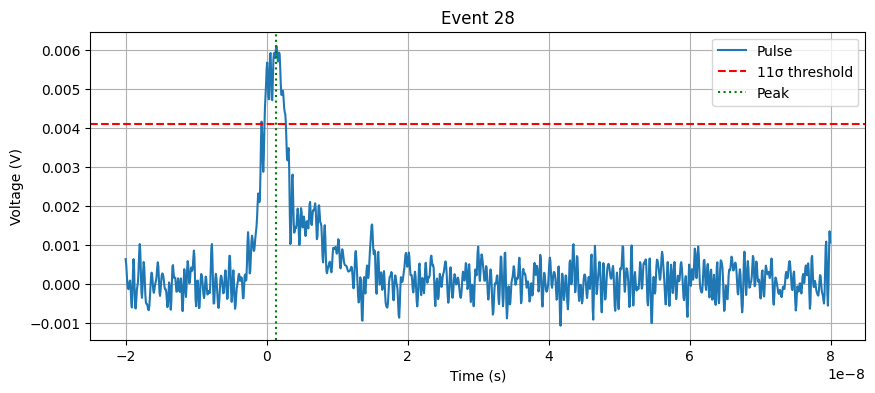

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.004846601255914507
amplitude: 0.004569811163101603


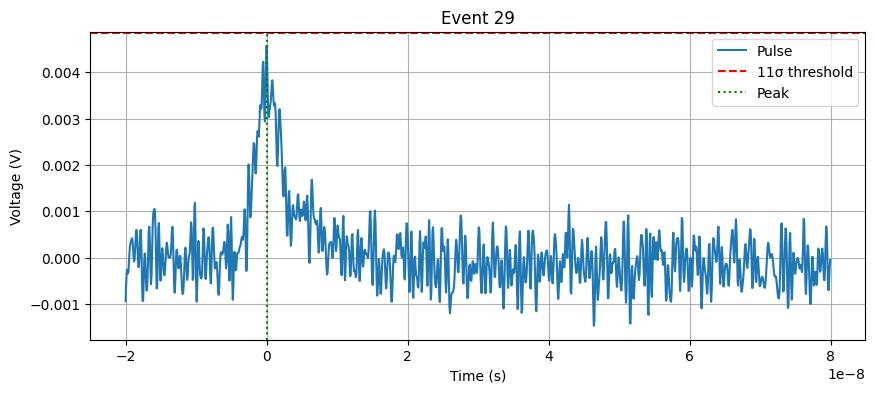

time_above: 1.634349558068583e-09
total_time_above 1.634349558068583e-09
first_crossing_time: -1.7242035438084742e-10
second_crossing_time: 1.4619292036877357e-09
11 sig thresh 0.004680445913335912
amplitude: 0.006393925467914439


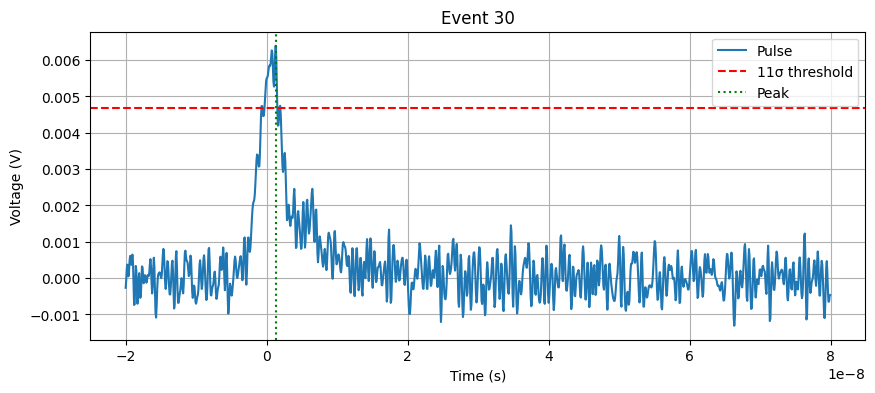

time_above: 2.1406377084574443e-09
total_time_above 2.1406377084574443e-09
first_crossing_time: -2.7596461266944244e-10
second_crossing_time: 1.8646730957880018e-09
11 sig thresh 0.004394196817910921
amplitude: 0.006951788101604272


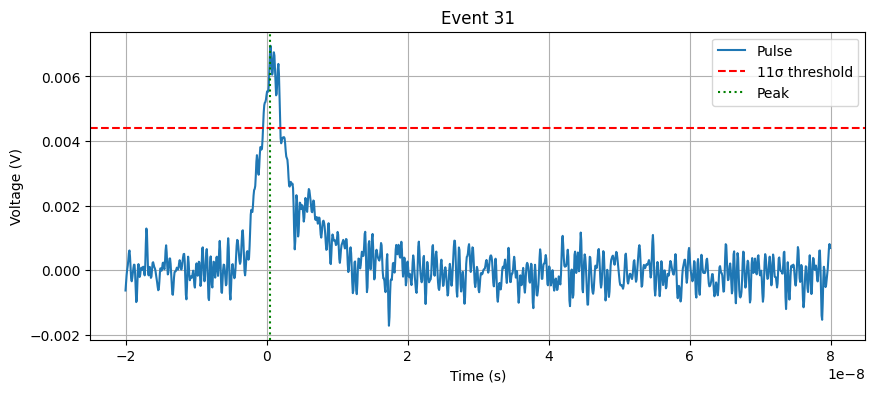

time_above: 1.5414866427470713e-09
total_time_above 1.5414866427470713e-09
first_crossing_time: -8.695712048165347e-10
second_crossing_time: 1.0880341255290388e-09
11 sig thresh 0.0045851426820924515
amplitude: 0.006370675969251338


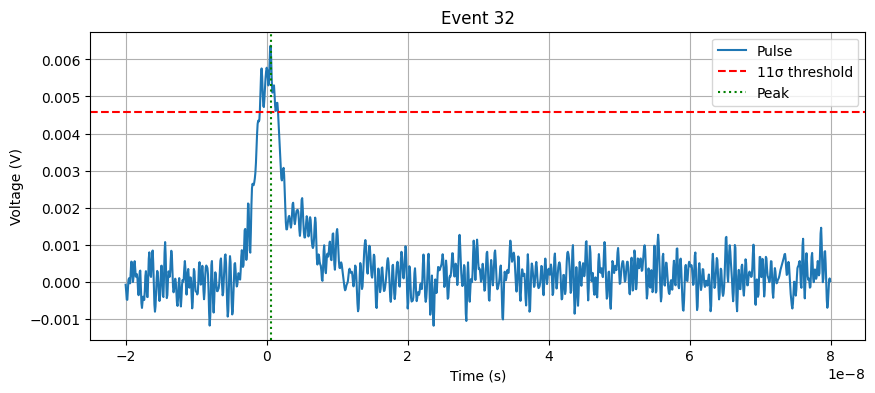

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.005050511371553248
amplitude: 0.0046918031417112266


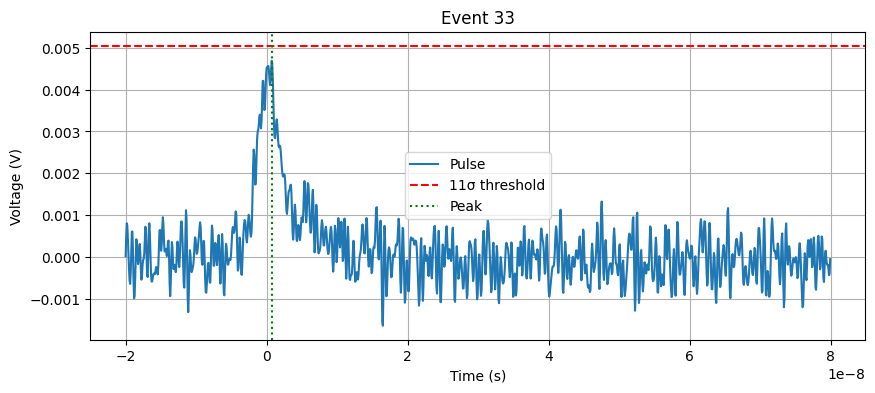

time_above: 1.2134043170817812e-09
total_time_above 1.2134043170817812e-09
first_crossing_time: -6.235855282070023e-10
second_crossing_time: 1.0013209840762605e-09
11 sig thresh 0.0051271787492992325
amplitude: 0.0062233455882352955


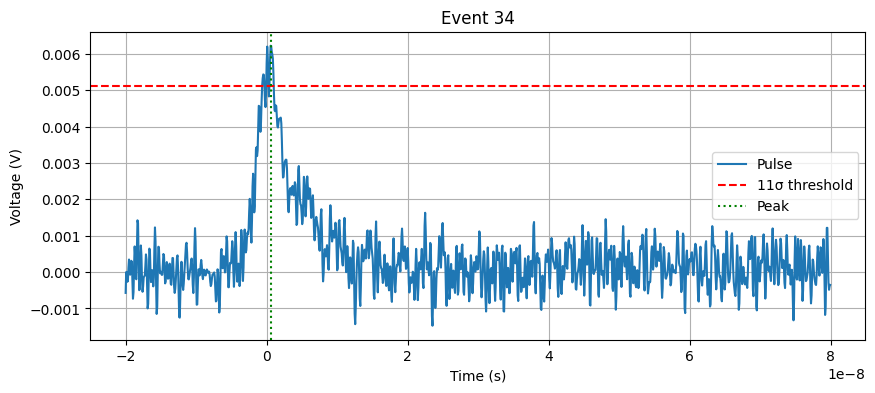

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.004472354410634186
amplitude: 0.004288728275401075


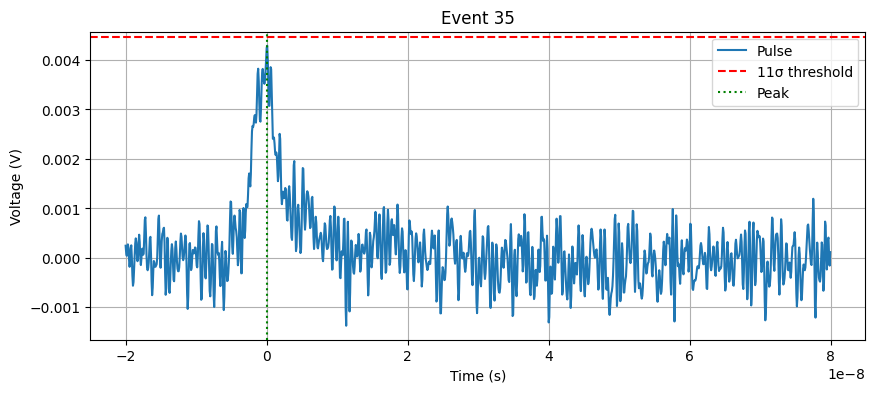

time_above: 2.33975684321249e-09
total_time_above 2.33975684321249e-09
first_crossing_time: -4.2793994084735463e-10
second_crossing_time: 1.9118169023651356e-09
11 sig thresh 0.00430597893826599
amplitude: 0.007013912098930485


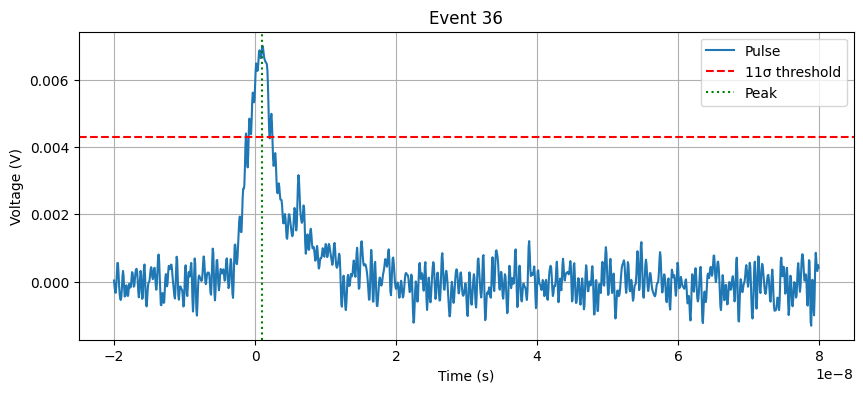

time_above: 1.1572314007781326e-08
total_time_above 1.1572314007781326e-08
first_crossing_time: 2.0733934350666546e-10
second_crossing_time: 2.3073538884298725e-08
11 sig thresh 0.006769017901256948
amplitude: 0.033792885193850264


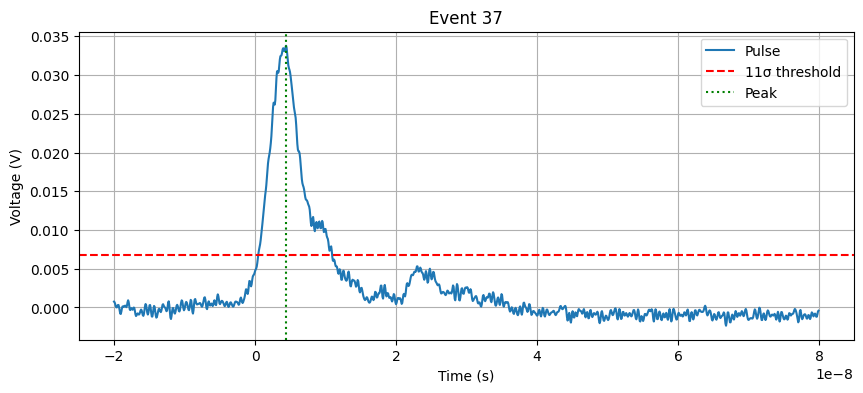

time_above: 8.094242427851427e-10
total_time_above 8.094242427851427e-10
first_crossing_time: -2.1792911886722605e-09
second_crossing_time: -2.1092376543824352e-11
11 sig thresh 0.005454010558810374
amplitude: 0.005589070855614969


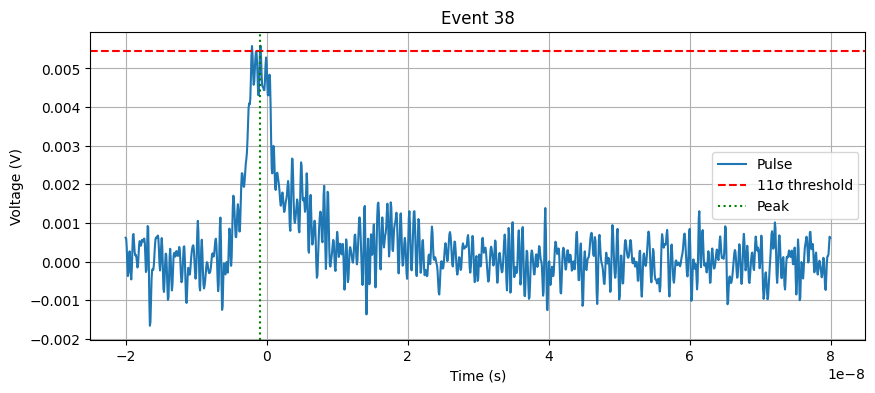

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.014753657831598833
amplitude: 0.0030878175133689833


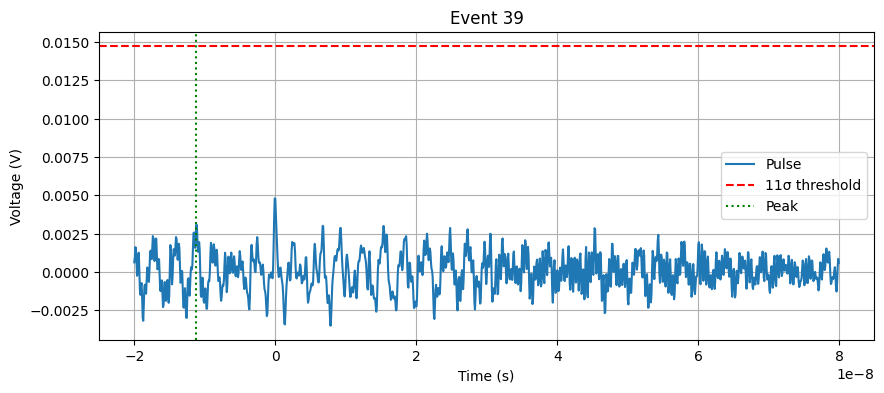

time_above: 1.4850980737169892e-10
total_time_above 1.4850980737169892e-10
first_crossing_time: 6.443171173971109e-10
second_crossing_time: 7.928269247688097e-10
11 sig thresh 0.005203559091286136
amplitude: 0.00534341577540107


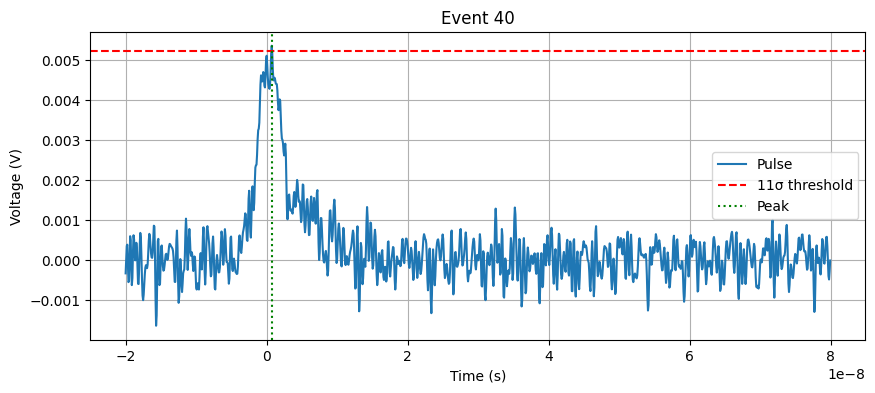

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.004729977129577963
amplitude: 0.0051107745655080234


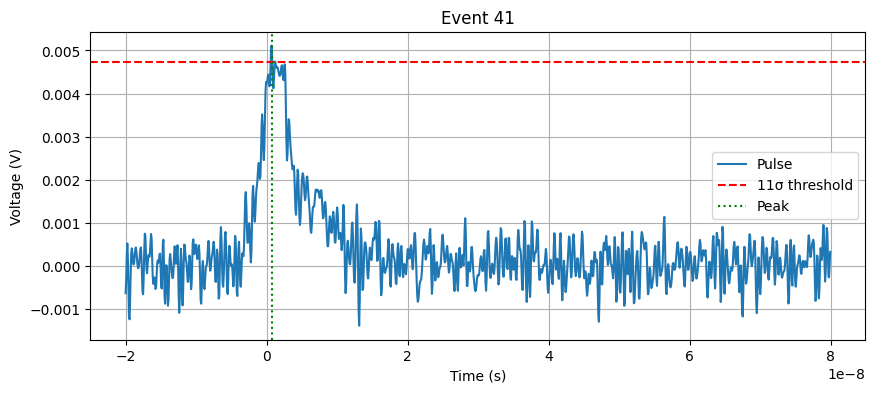

time_above: 1.0708497332513125e-09
total_time_above 1.0708497332513125e-09
first_crossing_time: -2.7508799644911734e-10
second_crossing_time: 1.0955556652611077e-09
11 sig thresh 0.004723467989017965
amplitude: 0.006332031249999995


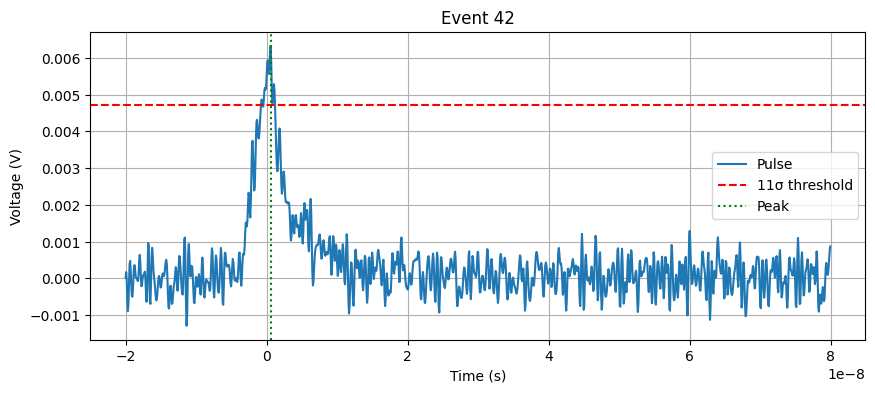

time_above: 6.9847855333138485e-09
total_time_above 6.9847855333138485e-09
first_crossing_time: -4.133732841771929e-10
second_crossing_time: 1.523531791983542e-08
11 sig thresh 0.013953627081973426
amplitude: 0.009749561330213898


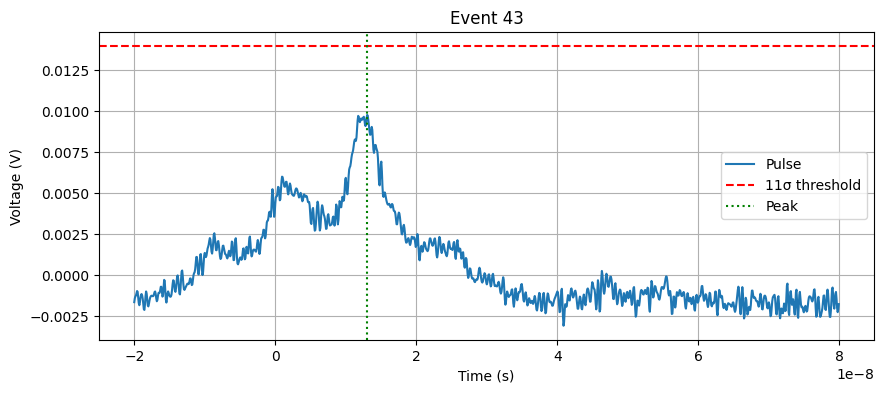

time_above: 1.1699997138766095e-09
total_time_above 1.1699997138766095e-09
first_crossing_time: -6.842513728778995e-11
second_crossing_time: 1.5788275942668803e-09
11 sig thresh 0.005106716061783705
amplitude: 0.006574657419786102


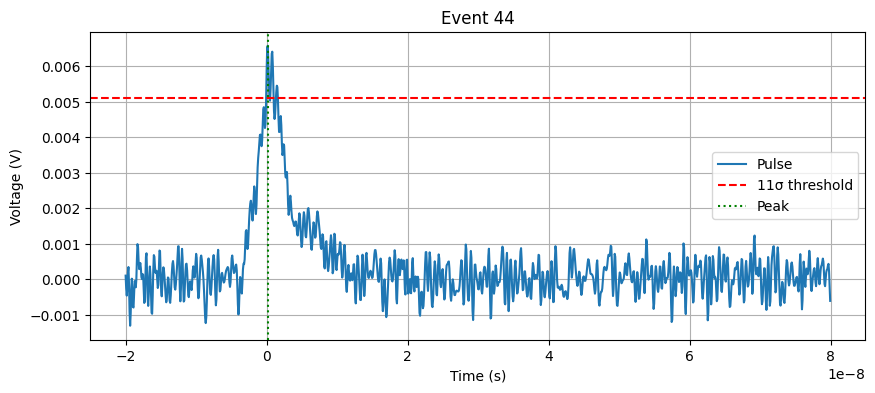

time_above: 2.345909619716368e-09
total_time_above 2.345909619716368e-09
first_crossing_time: -6.850437259835111e-11
second_crossing_time: 2.2774052471180168e-09
11 sig thresh 0.004735247650590492
amplitude: 0.006535594919786099


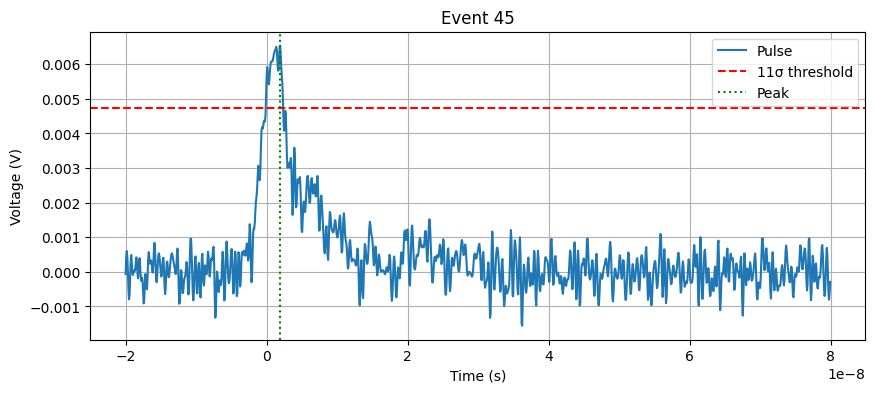

time_above: 1.1286664552561375e-09
total_time_above 1.1286664552561375e-09
first_crossing_time: -1.854647640543322e-10
second_crossing_time: 1.188807464437462e-09
11 sig thresh 0.0046630973439906265
amplitude: 0.005581697025401073


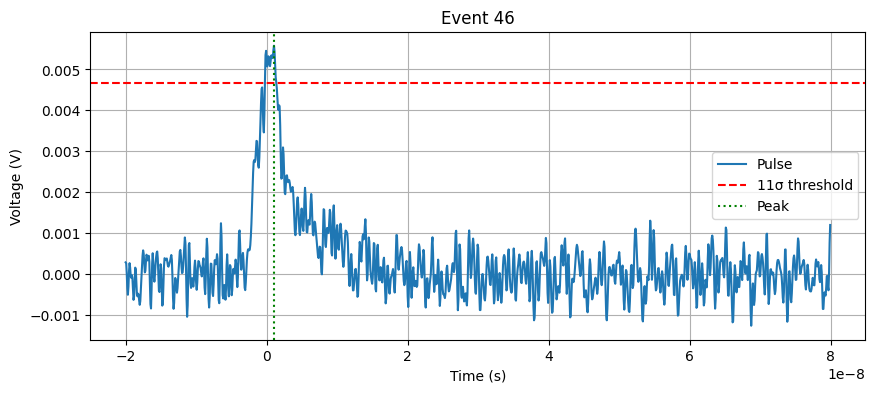

time_above: 1.2560794237375725e-10
total_time_above 1.2560794237375725e-10
first_crossing_time: -8.093300332564752e-11
second_crossing_time: 4.4674939048109736e-11
11 sig thresh 0.0053682595206360085
amplitude: 0.005355635862299468


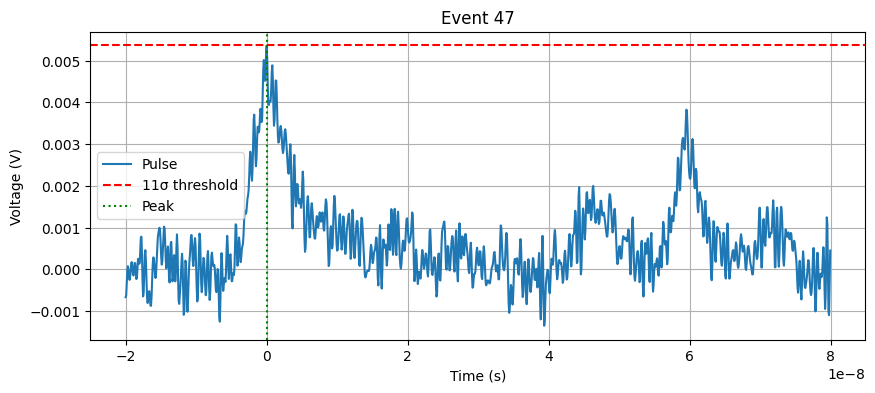

time_above: 6.976346938531849e-10
total_time_above 6.976346938531849e-10
first_crossing_time: -4.97808712506684e-10
second_crossing_time: 3.111707453069539e-10
11 sig thresh 0.004476638710881111
amplitude: 0.006214091744652401


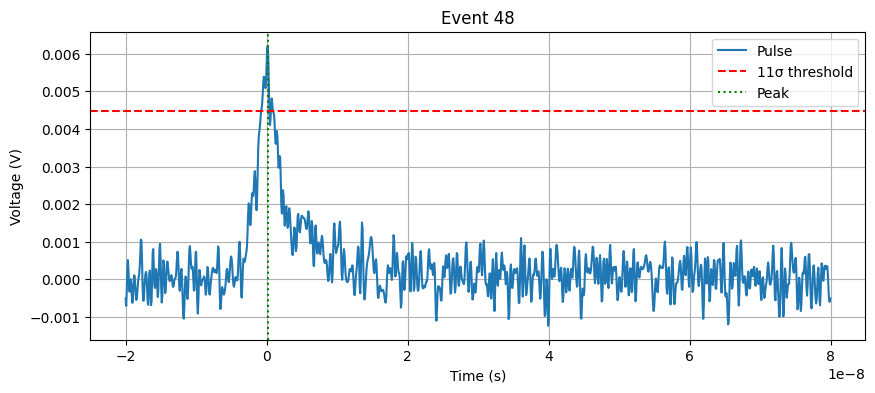

time_above: 5.171787662438819e-10
total_time_above 5.171787662438819e-10
first_crossing_time: -6.911457748947375e-10
second_crossing_time: 2.4894797269693016e-10
11 sig thresh 0.0050887001428525785
amplitude: 0.005741581717914438


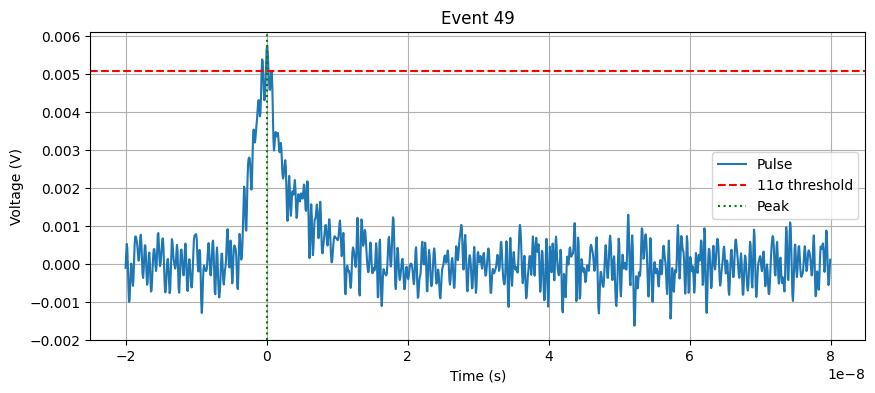

time_above: 2.2442877773586782e-09
total_time_above 2.2442877773586782e-09
first_crossing_time: -7.564721629220816e-11
second_crossing_time: 2.16864056106647e-09
11 sig thresh 0.004862563485897661
amplitude: 0.006620780414438504


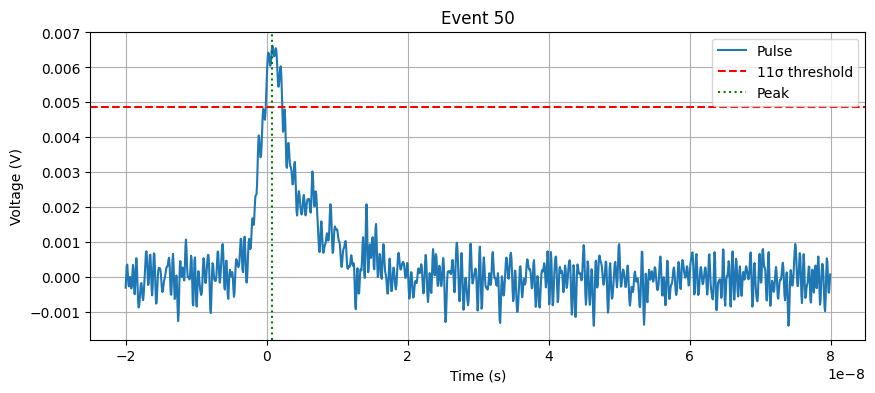

time_above: 6.628142216561435e-10
total_time_above 6.628142216561435e-10
first_crossing_time: -1.365085704507769e-10
second_crossing_time: 8.269022638694263e-10
11 sig thresh 0.0045415849680257615
amplitude: 0.005832281918449205


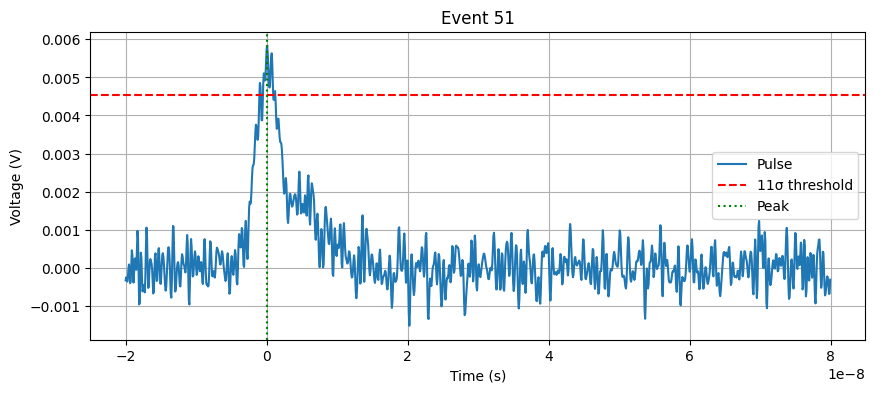

time_above: 1.42656855747748e-09
total_time_above 1.42656855747748e-09
first_crossing_time: -5.087040825600994e-10
second_crossing_time: 9.178644749173806e-10
11 sig thresh 0.0051714816642420966
amplitude: 0.006161785594919782


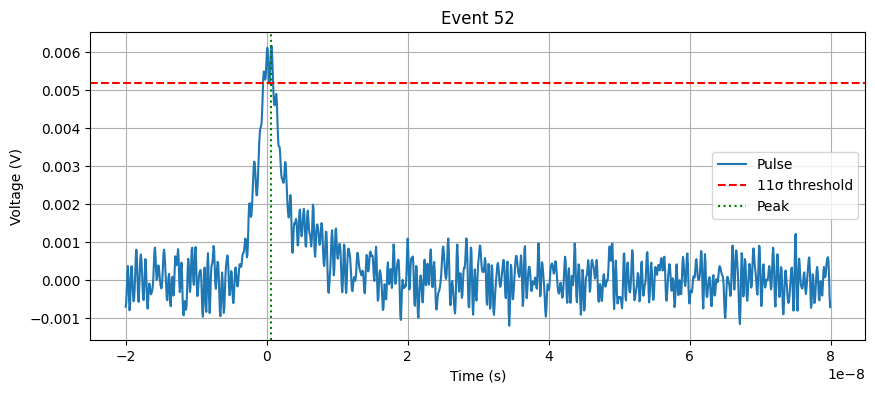

time_above: 1.365807620717015e-09
total_time_above 1.365807620717015e-09
first_crossing_time: -9.652790617093667e-11
second_crossing_time: 1.5106803508098747e-09
11 sig thresh 0.0049957523580735075
amplitude: 0.00623387366310161


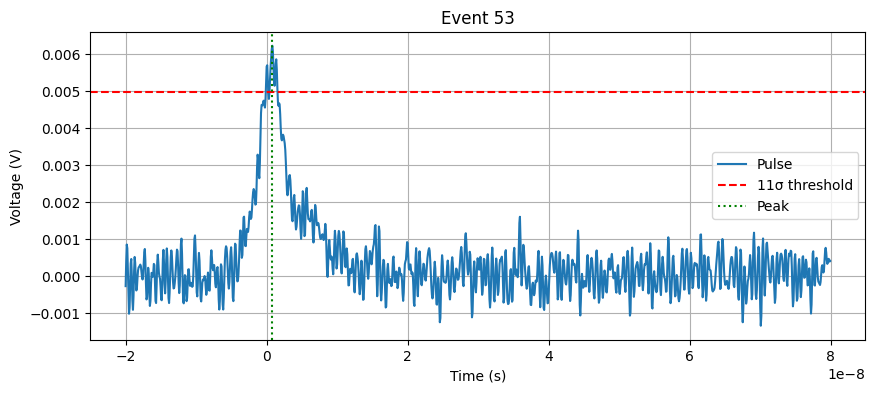

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.004374824698136464
amplitude: 0.004857829211229942


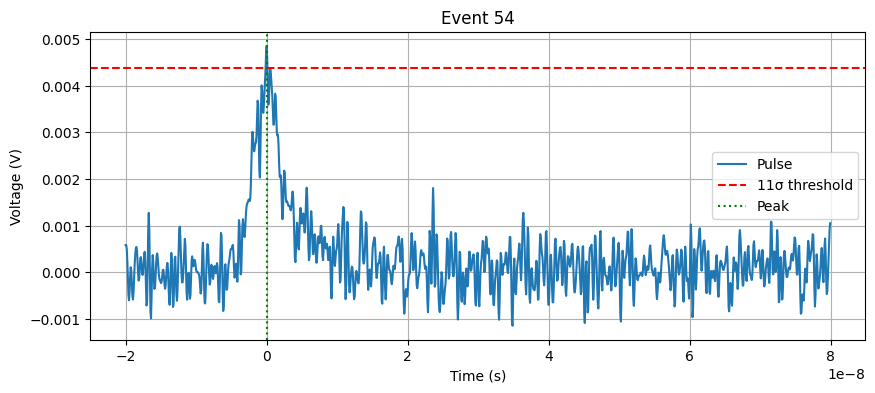

time_above: 2.070510472921013e-09
total_time_above 2.070510472921013e-09
first_crossing_time: -2.0111377957247287e-10
second_crossing_time: 1.8806513058274234e-09
11 sig thresh 0.004795848961127438
amplitude: 0.006699824532085555


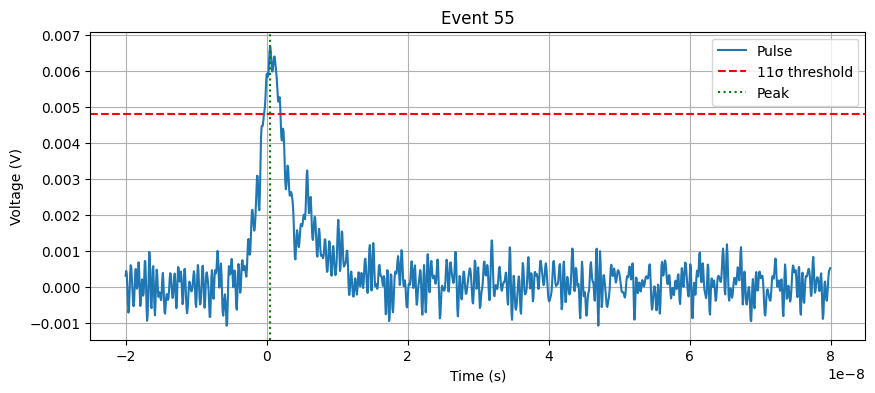

time_above: 3.0924444230753854e-10
total_time_above 3.0924444230753854e-10
first_crossing_time: -2.5483088848725796e-10
second_crossing_time: 1.977357320821984e-10
11 sig thresh 0.004298944505288449
amplitude: 0.005745822192513373


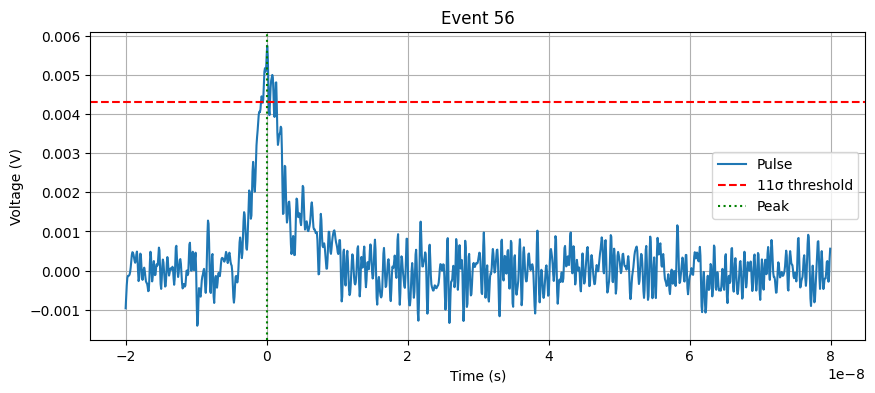

time_above: 2.1797755014457954e-09
total_time_above 2.1797755014457954e-09
first_crossing_time: -9.084426244958953e-11
second_crossing_time: 2.088931238996206e-09
11 sig thresh 0.004994302359882698
amplitude: 0.007053496824866308


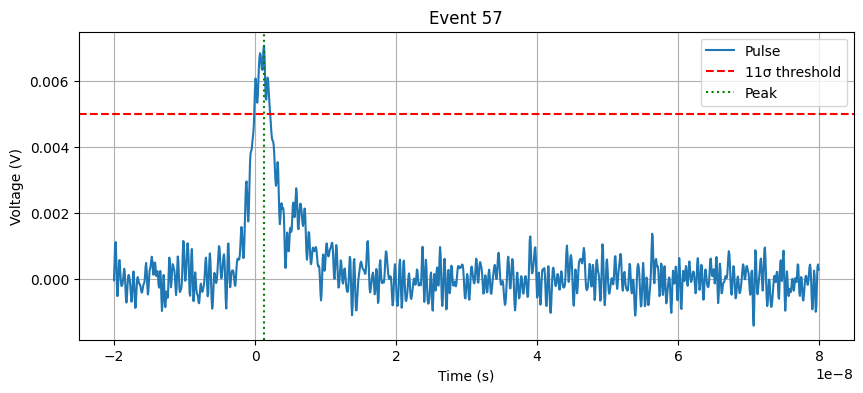

time_above: 2.358880637120202e-09
total_time_above 2.358880637120202e-09
first_crossing_time: -6.969390904094914e-11
second_crossing_time: 2.289186728079253e-09
11 sig thresh 0.003743209029668677
amplitude: 0.007356951871657747


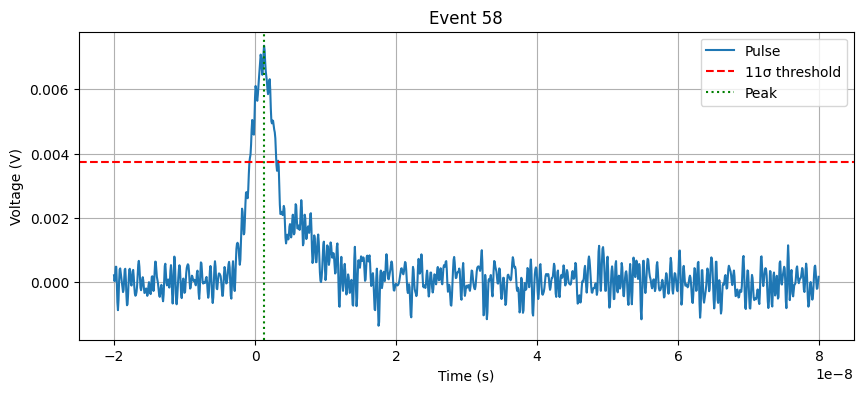

time_above: 2.1173432758662013e-10
total_time_above 2.1173432758662013e-10
first_crossing_time: -1.1006715512249844e-10
second_crossing_time: 1.016671724641217e-10
11 sig thresh 0.004998758856652493
amplitude: 0.005677494151069518


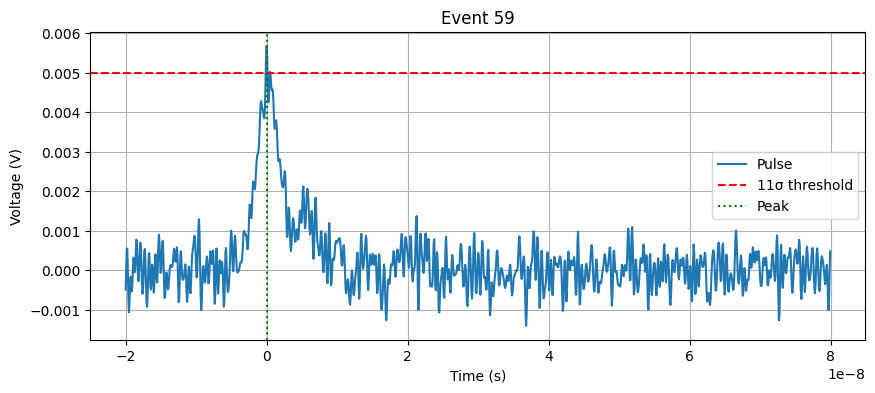

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.014060004779142703
amplitude: 0.004988657252673795


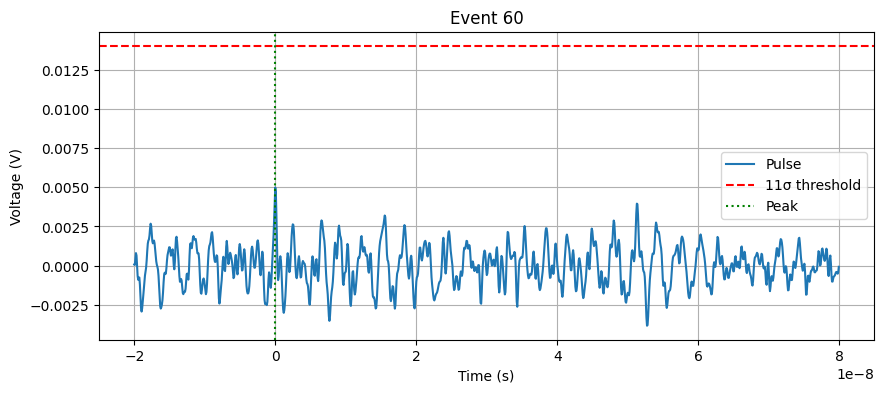

time_above: 7.797047922261116e-10
total_time_above 7.797047922261116e-10
first_crossing_time: -1.2333803584466227e-10
second_crossing_time: 7.426481500883402e-10
11 sig thresh 0.004443881650041006
amplitude: 0.006187855113636367


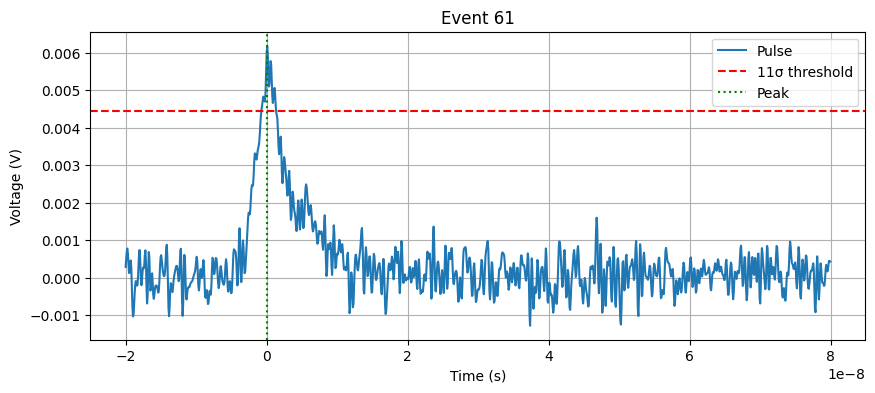

time_above: 2.6496484419541295e-08
total_time_above 2.6496484419541295e-08
first_crossing_time: -1.2043472461382662e-11
second_crossing_time: 2.6484440947079912e-08
11 sig thresh 0.0062614888368959214
amplitude: 0.01359719669117647


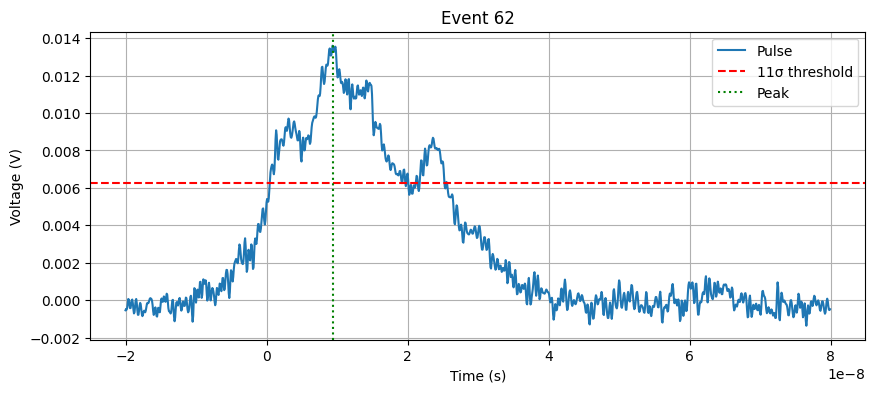

time_above: 7.052076266210315e-10
total_time_above 7.052076266210315e-10
first_crossing_time: -2.2983227236239712e-10
second_crossing_time: 6.821057293161838e-10
11 sig thresh 0.005149490404564476
amplitude: 0.005757540942513374


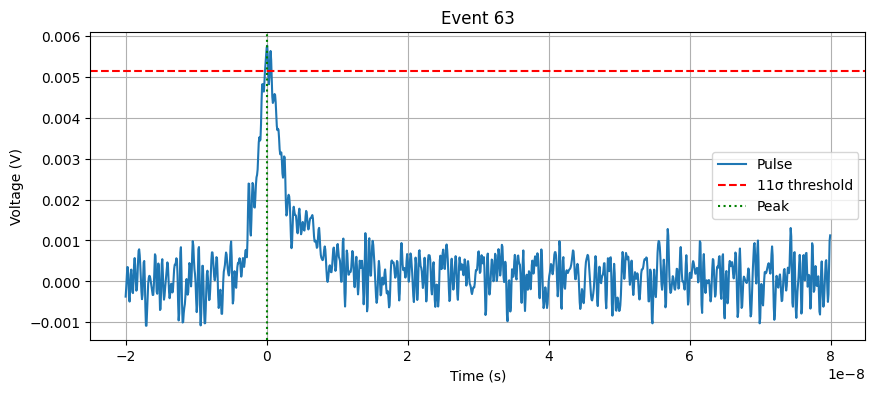

time_above: 1.8737032748940936e-09
total_time_above 1.8737032748940936e-09
first_crossing_time: -1.149110691282405e-10
second_crossing_time: 1.7587922057658531e-09
11 sig thresh 0.004995017390267921
amplitude: 0.006820939171122999


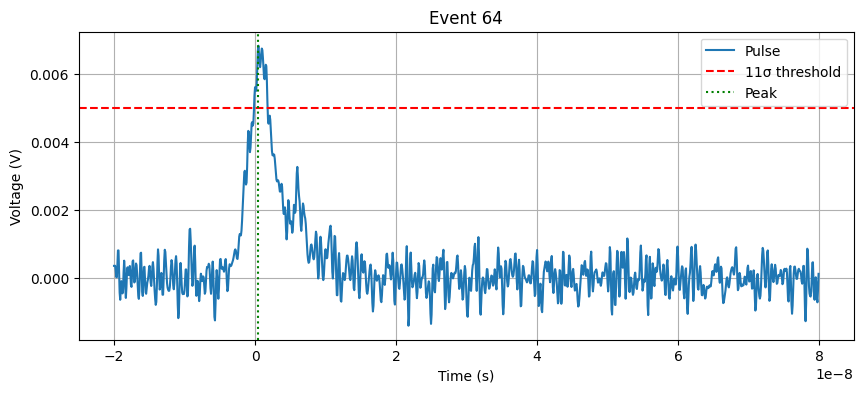

time_above: 2.013706996794572e-09
total_time_above 2.013706996794572e-09
first_crossing_time: -1.0526888533797903e-10
second_crossing_time: 2.4037181794330407e-09
11 sig thresh 0.004916676641902394
amplitude: 0.006608330548128344


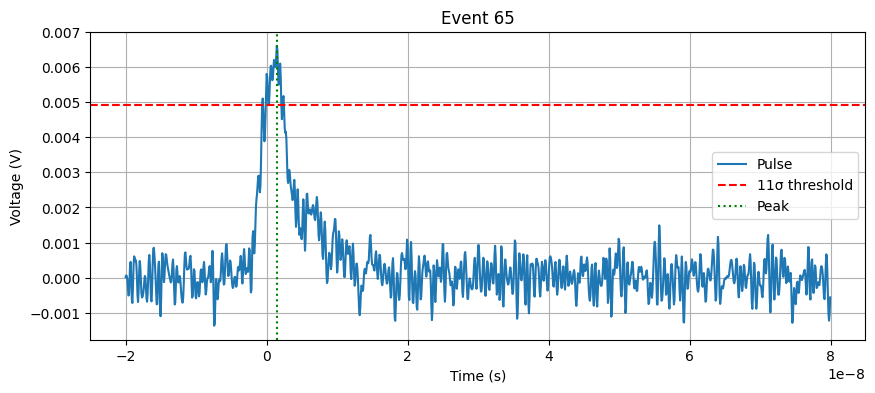

time_above: 1.7879210118583615e-09
total_time_above 1.7879210118583615e-09
first_crossing_time: -1.1946132125387303e-10
second_crossing_time: 1.8638534133084876e-09
11 sig thresh 0.005009547627942909
amplitude: 0.0063703835227272776


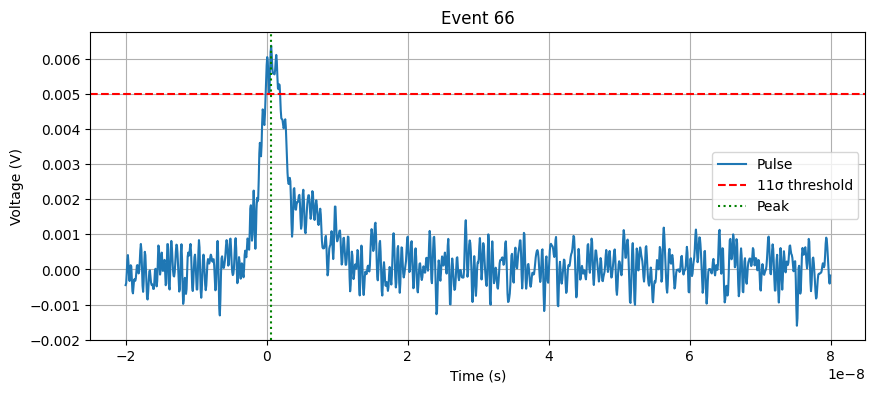

time_above: 5.648910981359621e-10
total_time_above 5.648910981359621e-10
first_crossing_time: -7.316855407833471e-10
second_crossing_time: 1.481179038333381e-10
11 sig thresh 0.004842072314770556
amplitude: 0.0061008313836898335


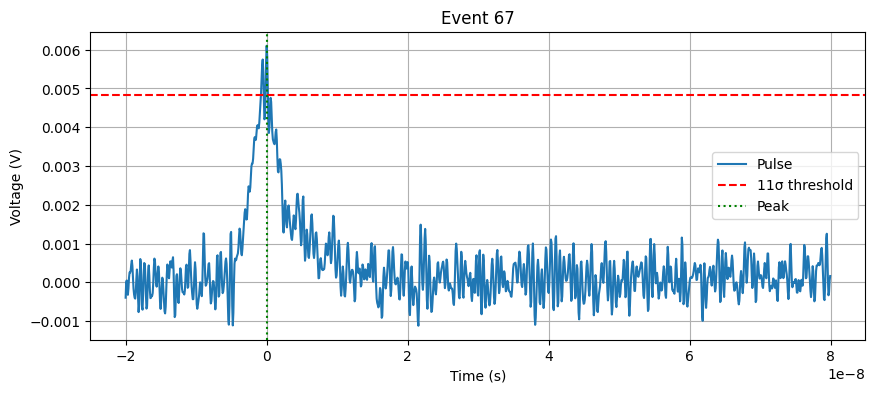

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.004820157170843689
amplitude: 0.0043790942513369045


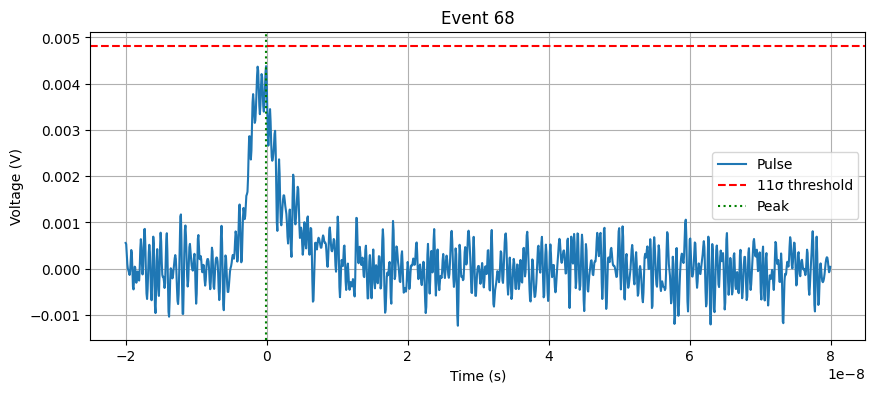

time_above: 1.2490932874600332e-08
total_time_above 1.2490932874600332e-08
first_crossing_time: -4.999575846777062e-09
second_crossing_time: 1.169352557340557e-08
11 sig thresh 0.014600431648874014
amplitude: 0.008377506684491979


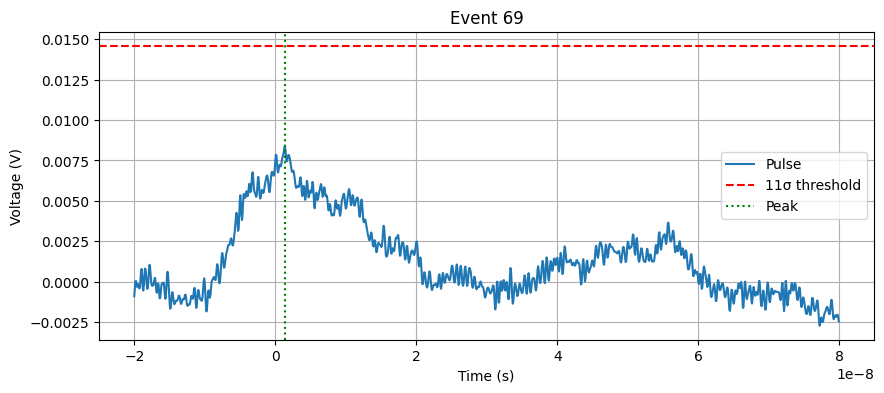

time_above: 1.161693460499929e-09
total_time_above 1.161693460499929e-09
first_crossing_time: -7.081501653068842e-10
second_crossing_time: 1.4291266290025108e-09
11 sig thresh 0.005505086989306055
amplitude: 0.005806003509358288


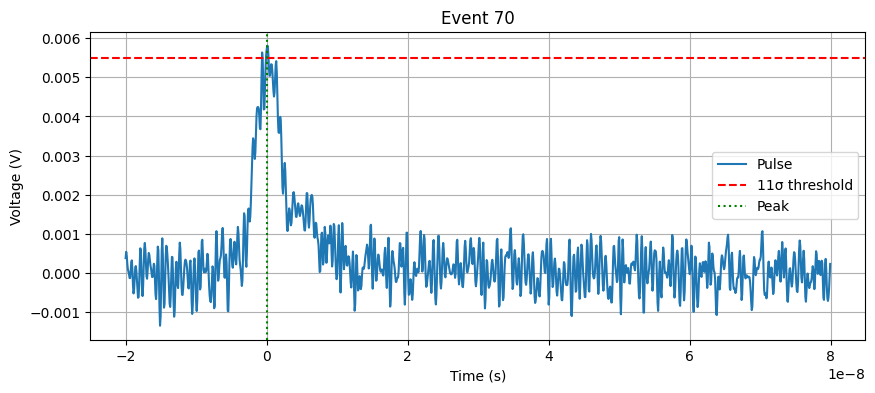

time_above: 6.046780288730663e-10
total_time_above 6.046780288730663e-10
first_crossing_time: -8.269018742245035e-11
second_crossing_time: 9.057362182949078e-10
11 sig thresh 0.00542367992690562
amplitude: 0.006227105614973266


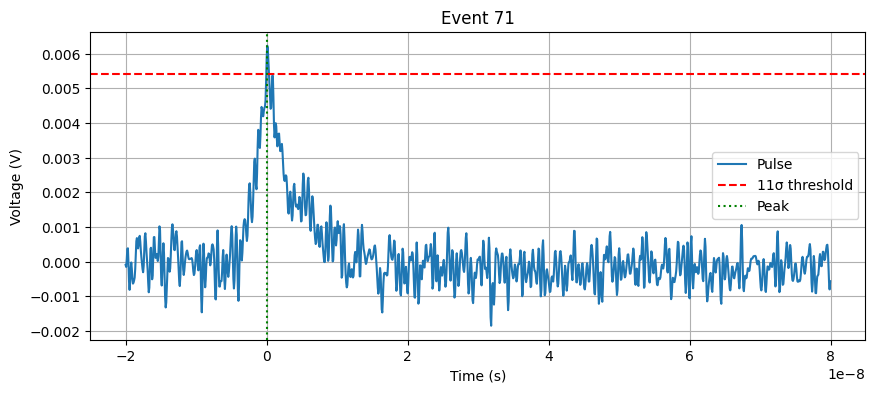

time_above: 1.2078737183163968e-09
total_time_above 1.2078737183163968e-09
first_crossing_time: -3.4394670486154304e-10
second_crossing_time: 1.1396724791677746e-09
11 sig thresh 0.005306863680194065
amplitude: 0.006136697860962568


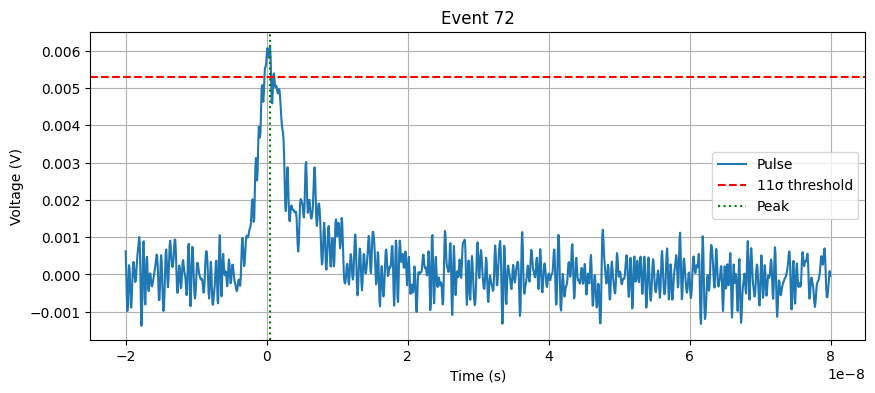

time_above: 4.5695266616401966e-10
total_time_above 4.5695266616401966e-10
first_crossing_time: -9.591512383106497e-10
second_crossing_time: 9.77188572603529e-11
11 sig thresh 0.004510837030948334
amplitude: 0.005768653910427807


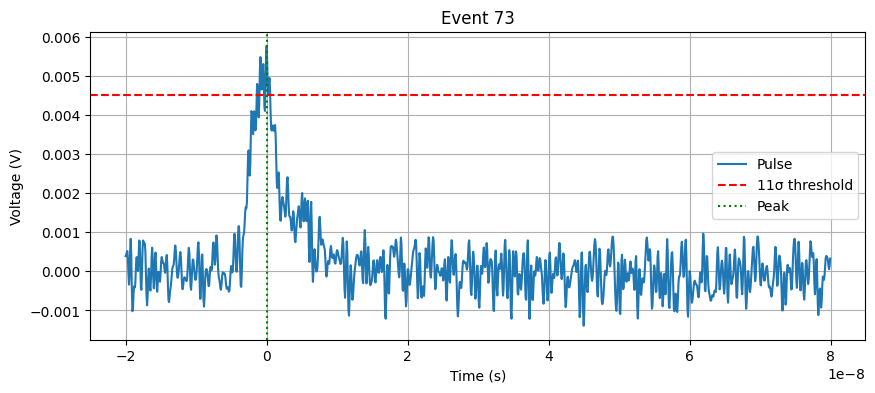

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.00449695595995488
amplitude: 0.004902615307486637


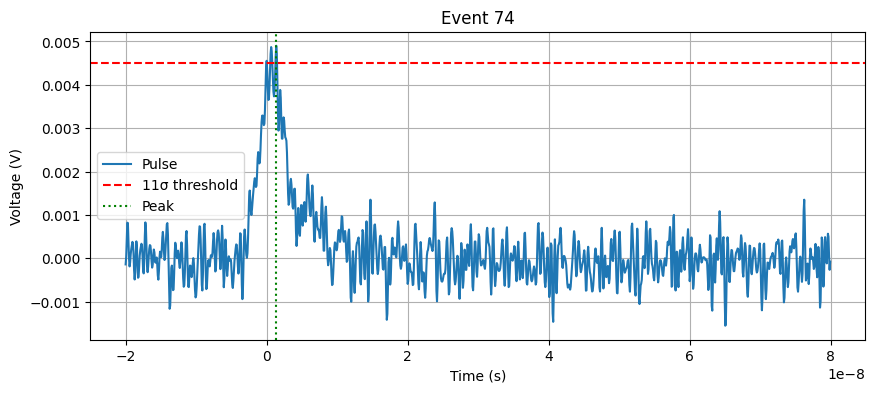

time_above: 3.098865045307323e-09
total_time_above 3.098865045307323e-09
first_crossing_time: -4.7327380660591975e-11
second_crossing_time: 3.051537664646731e-09
11 sig thresh 0.004585251644023772
amplitude: 0.00883136280080214


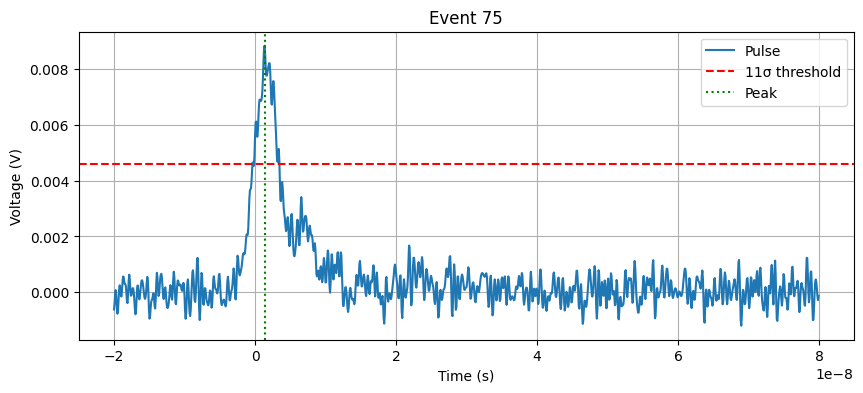

time_above: 2.1316714341281725e-09
total_time_above 2.1316714341281725e-09
first_crossing_time: -5.506118414965709e-10
second_crossing_time: 1.633335954870327e-09
11 sig thresh 0.005037461222046023
amplitude: 0.007020199699197855


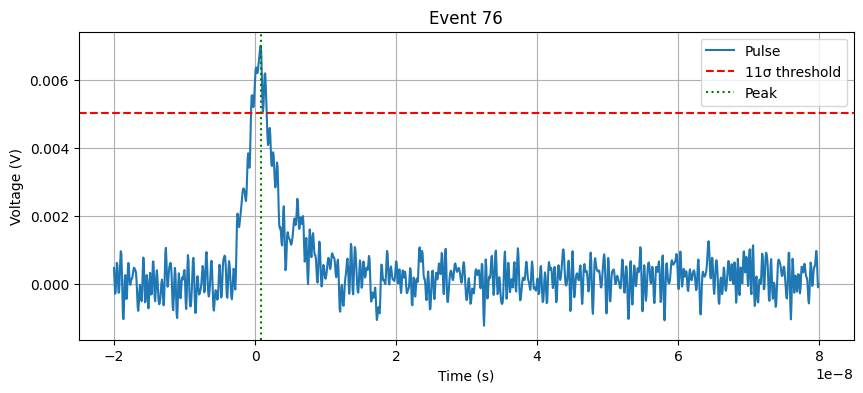

time_above: 6.688339862495294e-10
total_time_above 6.688339862495294e-10
first_crossing_time: -1.2366233488238663e-10
second_crossing_time: 8.757181421725451e-10
11 sig thresh 0.0045617876576181556
amplitude: 0.0056433823529411795


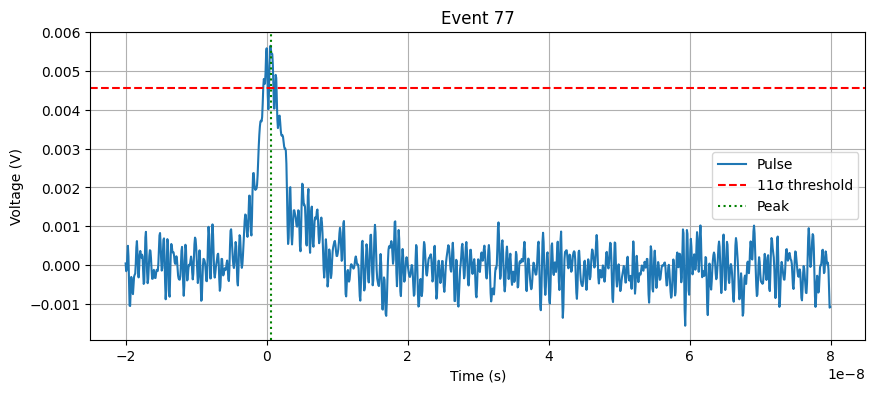

time_above: 2.5398425422086247e-09
total_time_above 2.5398425422086247e-09
first_crossing_time: -8.379146820925787e-11
second_crossing_time: 2.456051073999367e-09
11 sig thresh 0.004682322106355297
amplitude: 0.006509546290106956


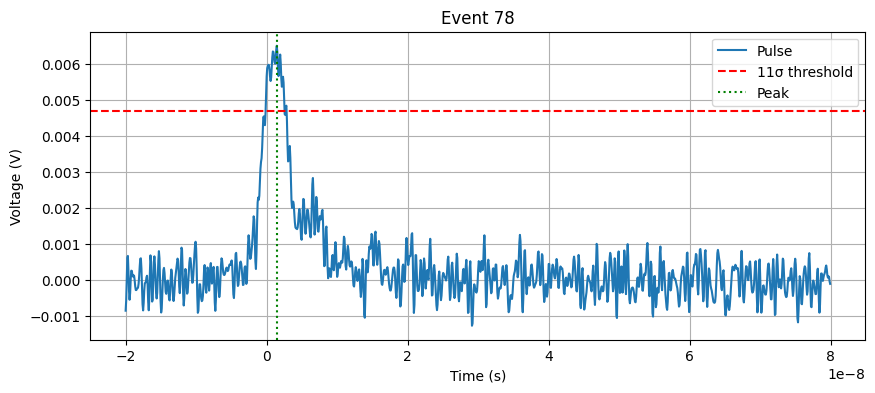

time_above: 2.9643741987161093e-09
total_time_above 2.9643741987161093e-09
first_crossing_time: -1.6646478148686636e-10
second_crossing_time: 2.797909417229243e-09
11 sig thresh 0.004334265868101763
amplitude: 0.0073352272727272684


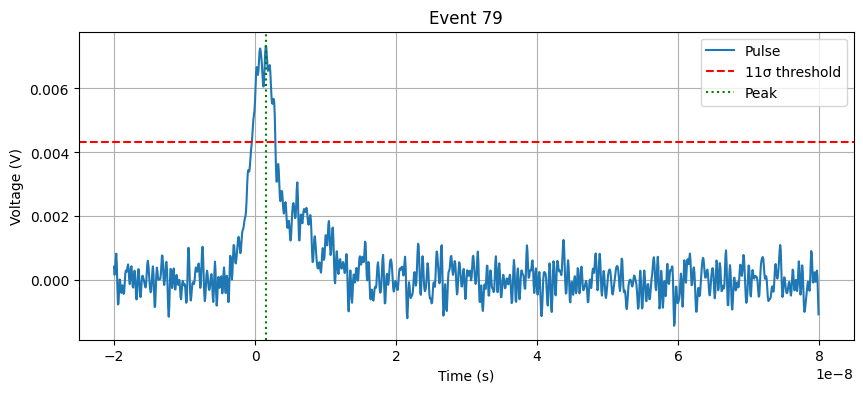

time_above: 2.0717682123548937e-09
total_time_above 2.0717682123548937e-09
first_crossing_time: -6.240354593283661e-11
second_crossing_time: 2.2182926438053505e-09
11 sig thresh 0.004961829804701894
amplitude: 0.0066673211898395784


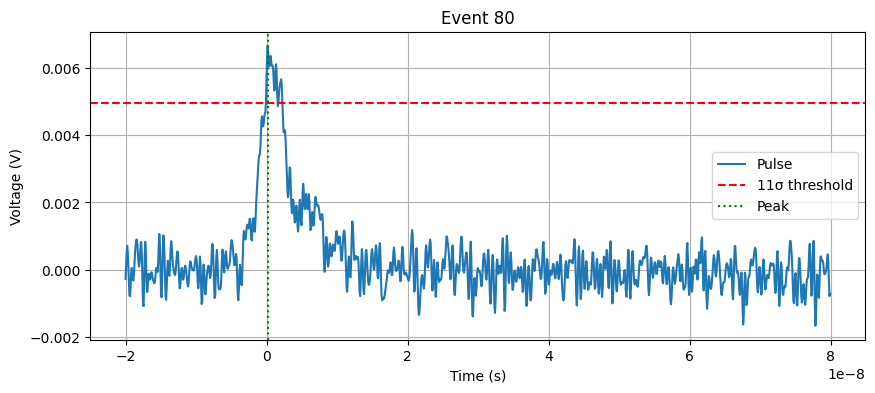

time_above: 9.614931346403406e-10
total_time_above 9.614931346403406e-10
first_crossing_time: -1.3021271889911908e-10
second_crossing_time: 1.5945113665157364e-09
11 sig thresh 0.0041650617437015815
amplitude: 0.005622284425133696


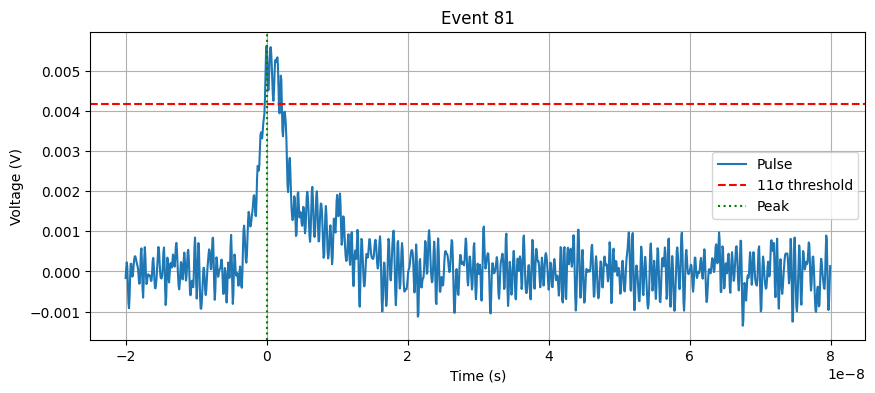

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.004561381124507917
amplitude: 0.004956404578876999


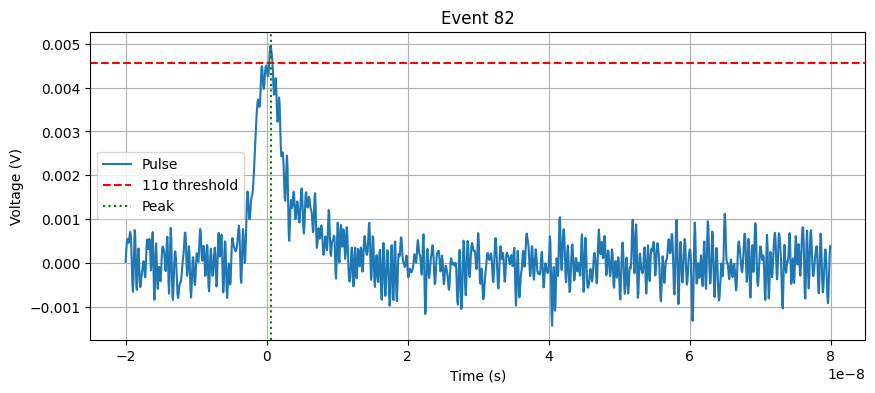

time_above: 1.626220102854289e-09
total_time_above 1.626220102854289e-09
first_crossing_time: -1.6228902304096246e-09
second_crossing_time: 1.2119266261658908e-10
11 sig thresh 0.004171948241486751
amplitude: 0.006963214405080209


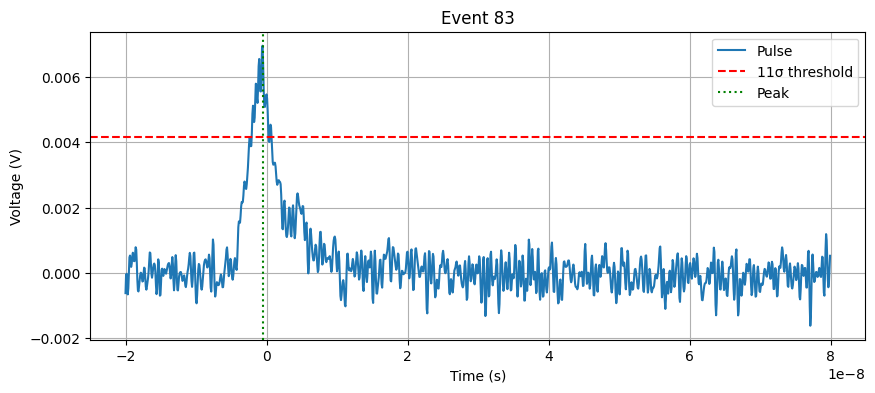

time_above: 4.107290824978021e-09
total_time_above 4.107290824978021e-09
first_crossing_time: -1.901756543055948e-10
second_crossing_time: 3.9171151706724255e-09
11 sig thresh 0.0053440859856574985
amplitude: 0.009484855447860966


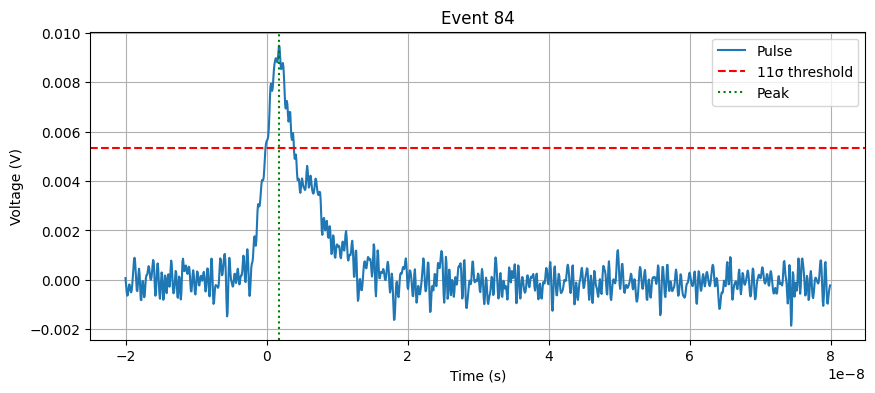

time_above: 1.2651012055535327e-09
total_time_above 1.2651012055535327e-09
first_crossing_time: -4.066435490521802e-10
second_crossing_time: 1.5874207397370524e-09
11 sig thresh 0.004854717453790792
amplitude: 0.006448821858288765


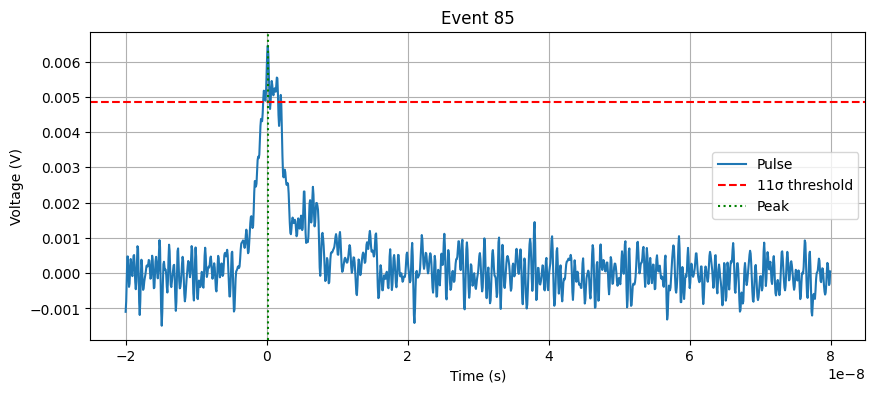

time_above: 6.077624256534732e-10
total_time_above 6.077624256534732e-10
first_crossing_time: -1.4183174240379688e-10
second_crossing_time: 7.508281625069219e-10
11 sig thresh 0.004353190502709142
amplitude: 0.006030706885026735


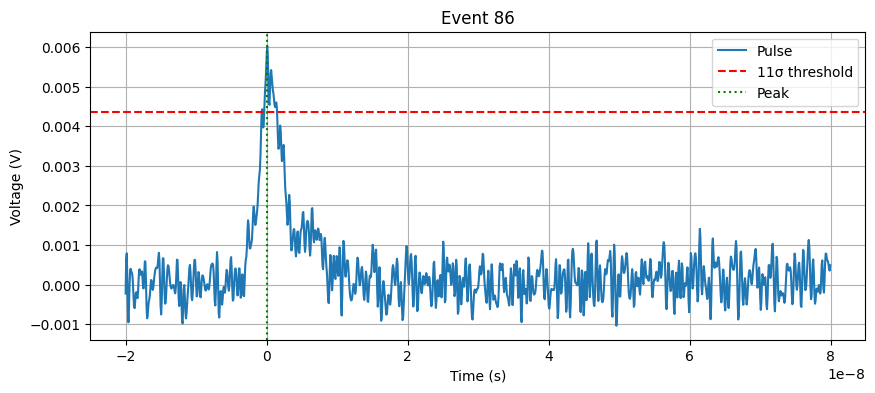

time_above: 1.1291634391520784e-10
total_time_above 1.1291634391520784e-10
first_crossing_time: 7.634195013906065e-11
second_crossing_time: 1.892582940542685e-10
11 sig thresh 0.005262362834339256
amplitude: 0.005229236296791446


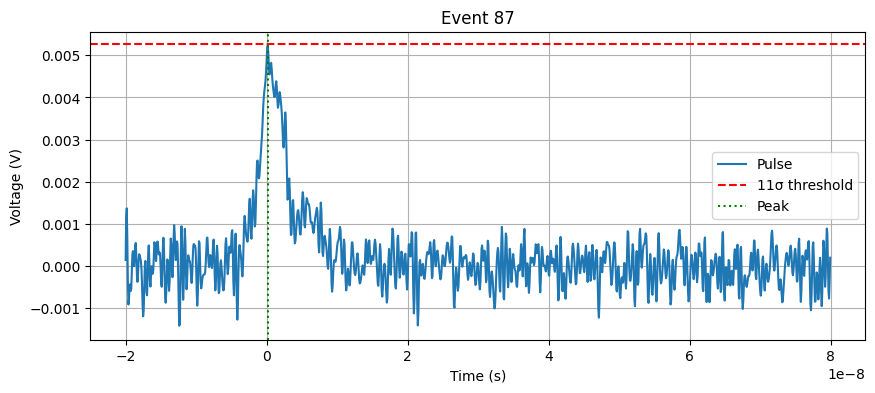

time_above: 1.572862802307317e-09
total_time_above 1.572862802307317e-09
first_crossing_time: -4.751905264199943e-10
second_crossing_time: 1.2372649912080355e-09
11 sig thresh 0.004520236161747812
amplitude: 0.006691489806149734


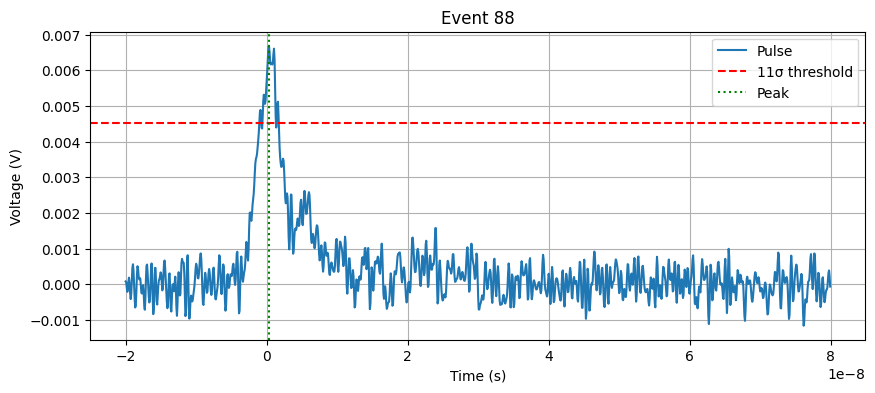

time_above: 7.650511799633057e-10
total_time_above 7.650511799633057e-10
first_crossing_time: -6.153334383841082e-10
second_crossing_time: 8.077690382639805e-10
11 sig thresh 0.004524062232443613
amplitude: 0.005891732118983957


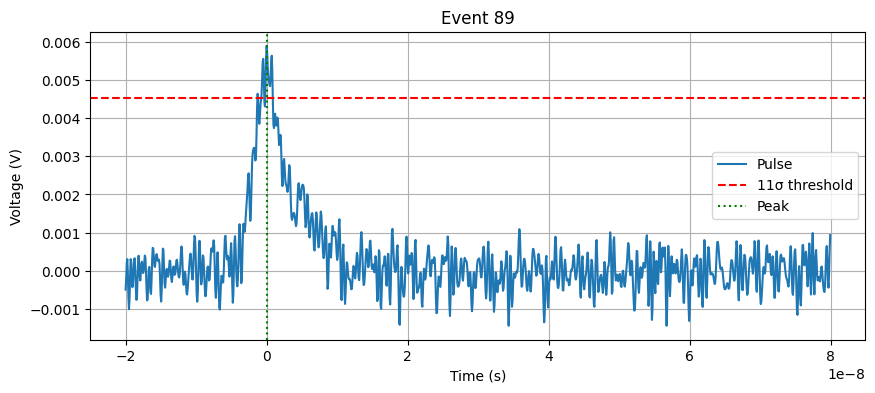

time_above: 8.101543708969118e-10
total_time_above 8.101543708969118e-10
first_crossing_time: 6.063347016695682e-10
second_crossing_time: 2.1089501567282163e-09
11 sig thresh 0.005130269195482028
amplitude: 0.00571672376336899


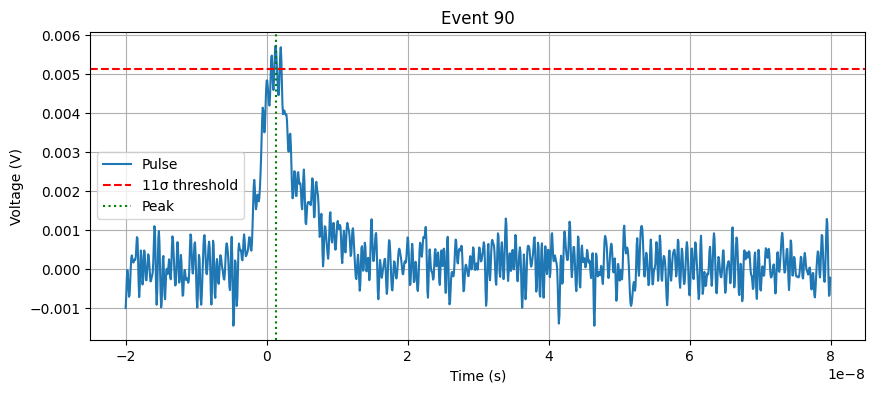

time_above: 1.34866030134107e-09
total_time_above 1.34866030134107e-09
first_crossing_time: -8.063047180879877e-10
second_crossing_time: 1.3758219899499062e-09
11 sig thresh 0.007619955400618793
amplitude: 0.006697505848930482


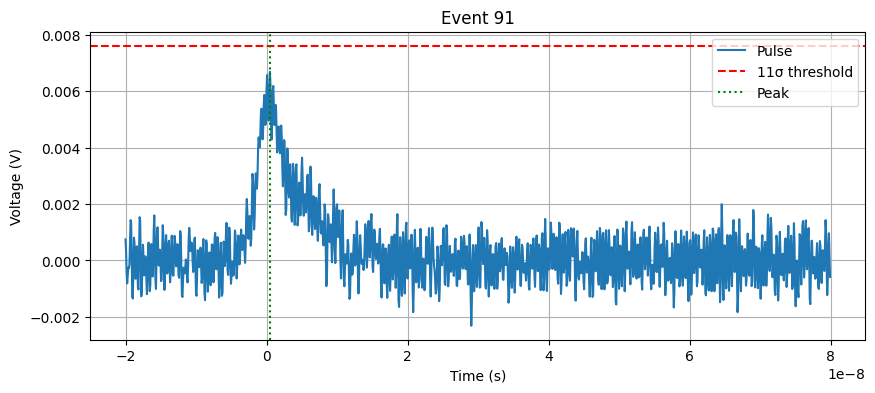

time_above: 1.9631515797591983e-10
total_time_above 1.9631515797591983e-10
first_crossing_time: -2.542238812478858e-11
second_crossing_time: 1.7089276985113125e-10
11 sig thresh 0.005408472668546774
amplitude: 0.005583117479946529


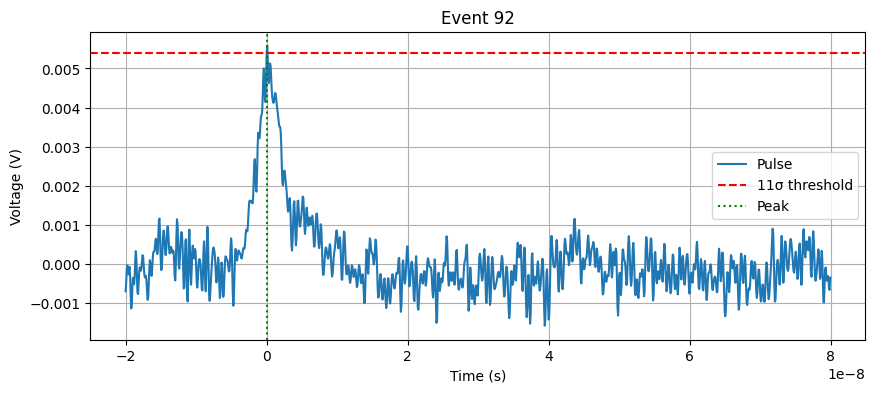

time_above: None
total_time_above None
first_crossing_time: None
second_crossing_time: None
11 sig thresh 0.020744098952311527
amplitude: 0.003835895721925127


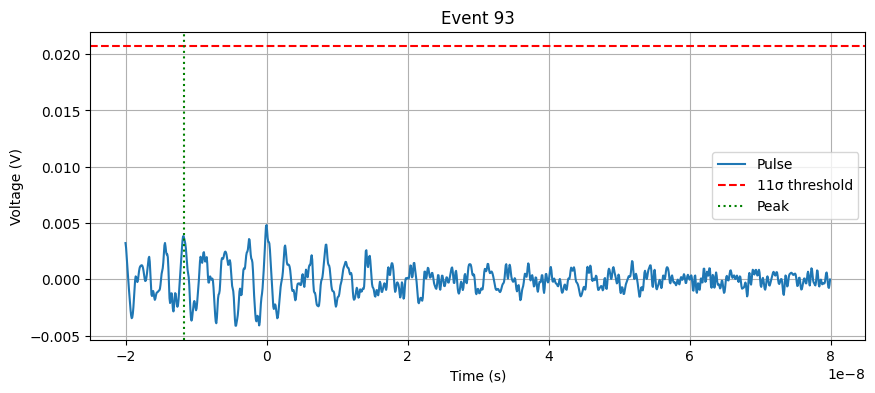

time_above: 9.78685213665854e-10
total_time_above 9.78685213665854e-10
first_crossing_time: -9.005751445678036e-10
second_crossing_time: 8.407387862442457e-10
11 sig thresh 0.004726208529867826
amplitude: 0.0056840950868983975


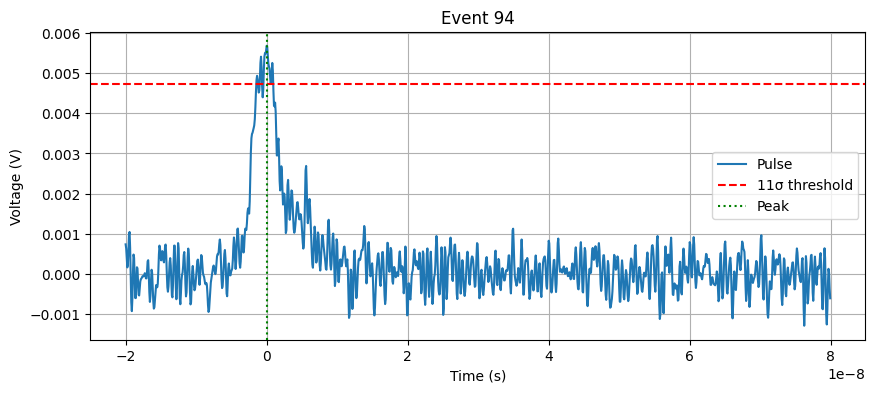

time_above: 1.8613963460433932e-09
total_time_above 1.8613963460433932e-09
first_crossing_time: -4.362618244549146e-10
second_crossing_time: 1.64941286820112e-09
11 sig thresh 0.005242499847715363
amplitude: 0.006786848262032088


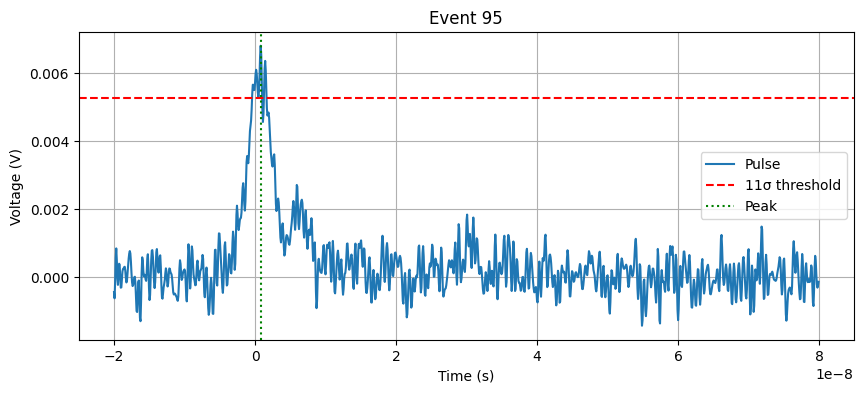

time_above: 2.742881384761206e-09
total_time_above 2.742881384761206e-09
first_crossing_time: -1.2236090532992823e-10
second_crossing_time: 2.670326557224832e-09
11 sig thresh 0.004872430239444409
amplitude: 0.0071850977606951905


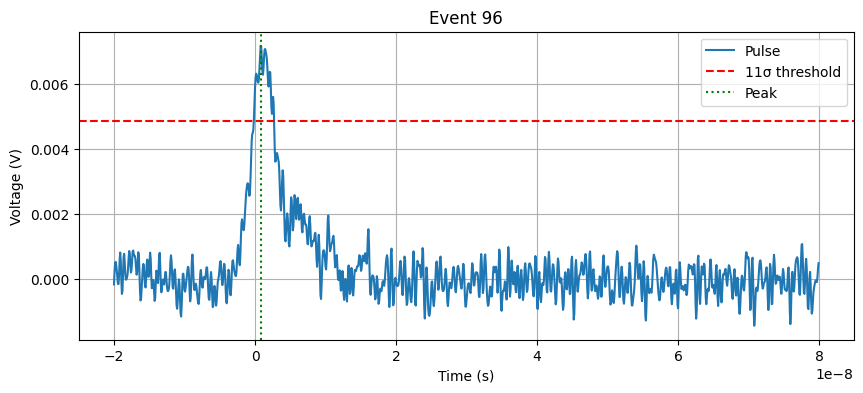

time_above: 5.777554649689819e-10
total_time_above 5.777554649689819e-10
first_crossing_time: -5.068002789149754e-10
second_crossing_time: 4.182879647439455e-10
11 sig thresh 0.005116325559405297
amplitude: 0.005693014705882351


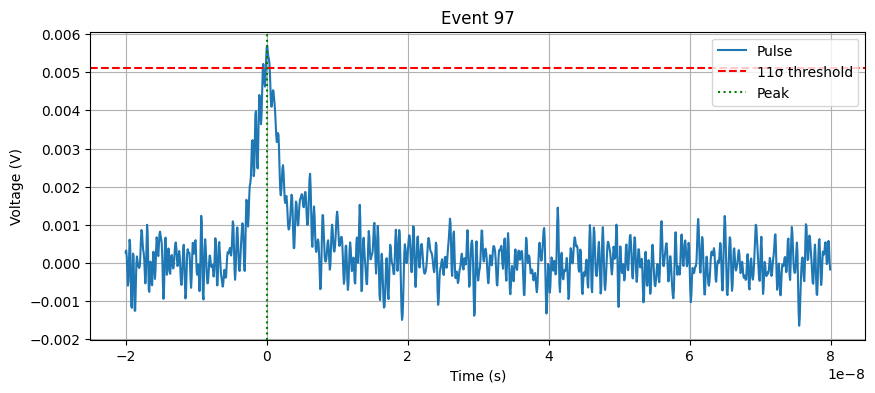

time_above: 2.5032074399996962e-08
total_time_above 2.5032074399996962e-08
first_crossing_time: -1.2309551341807717e-09
second_crossing_time: 2.397975214526914e-08
11 sig thresh 0.010676418953371989
amplitude: 0.017885340073529418


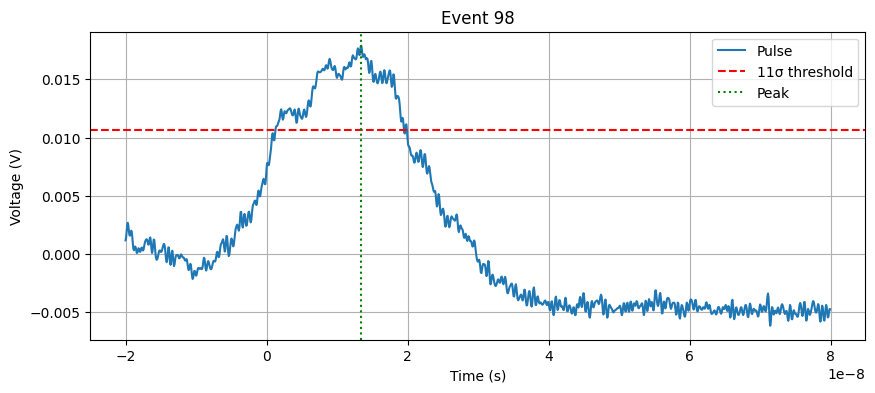

time_above: 5.096774370576081e-10
total_time_above 5.096774370576081e-10
first_crossing_time: -5.808569841247659e-10
second_crossing_time: 2.407524738656428e-10
11 sig thresh 0.005154947659544278
amplitude: 0.006050091911764712


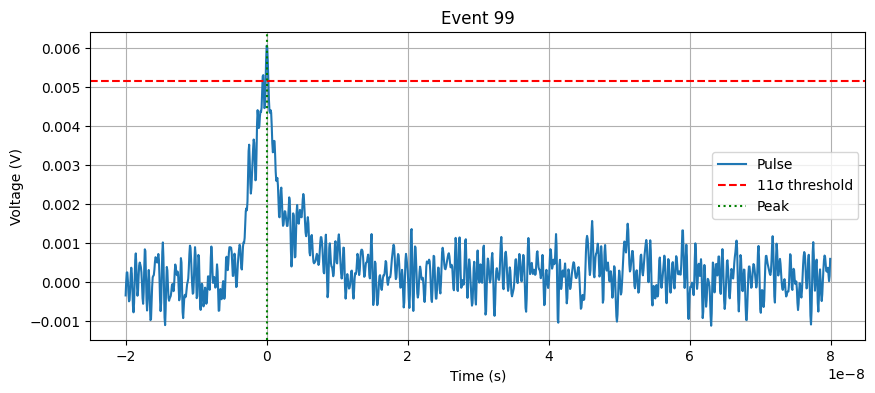

Analysis done, now printing plots


In [ ]:
def debug_plot_pulse(corrected, times, mean_b, sigma_b, peak_index, event_index):
    threshold = 11*sigma_b

    plt.figure(figsize=(10, 4))
    plt.plot(times, corrected, label="Pulse")
    plt.axhline(threshold, color='r', linestyle='--', label='11σ threshold')
    plt.axvline(times[peak_index], color='g', linestyle=':', label='Peak')

    plt.title(f"Event {event_index}")
    plt.xlabel("Time (s)")
    plt.ylabel("Voltage (V)")
    plt.legend()
    plt.grid(True)
    plt.show()

for event_index, corrected_tempVolt in enumerate(corrected_tempVolts): 

    amplitude, first_peak_index, first_peak_time, number_of_peaks = calcamplitude(corrected_tempVolt, samples, sigma_b)
    singleFWHM, left_time, right_time = peak_FWHM(corrected_tempVolt, amplitude, first_peak_index, sampleTimes)
    time_above, first_cross, second_cross = time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b, first_peak_index)
    total_time = total_time_above_threshold(corrected_tempVolt, sampleTimes, sigma_b)

    if event_index < 100:
        print("time_above:", time_above)
        print("total_time_above", total_time)
        print("first_crossing_time:", first_cross)
        print("second_crossing_time:", second_cross)
        print('11 sig thresh', 11*sigma_b_array[event_index])
        print('amplitude:', amplitude)
    if event_index < 100:   # change 5 → 20 if you want more
        debug_plot_pulse(
            corrected_tempVolt,
            sampleTimes,
            mean_b_array[event_index],
            sigma_b_array[event_index],
            first_peak_index,
            event_index)

    closest_index = time_index(first_cross, sampleTimes)
    single_integral = single_charge_integral(corrected_tempVolt, sampleTimes, closest_index)

    all_amplitudes.append(amplitude)
    all_peak_times.append(first_peak_time)
    all_peak_indices.append(first_peak_index)
    all_FWHM.append(singleFWHM)
    all_t1.append(left_time)
    all_t2.append(right_time)
    all_time_above_thresh.append(time_above)
    all_first_crossing.append(first_cross)
    all_second_crossing.append(second_cross)
    all_closest_indices.append(closest_index)
    all_integrals.append(single_integral)

all_amplitudes = np.array(all_amplitudes)
all_peak_times = np.array(all_peak_times)
all_peak_indices = np.array(all_peak_indices)
all_FWHM = np.array(all_FWHM)
all_t1 = np.array(all_t1)
all_t2 = np.array(all_t2)
all_time_above_thresh = np.array(all_time_above_thresh)
all_first_crossing = np.array(all_first_crossing)
all_second_crossing = np.array(all_second_crossing)
all_closest_indices = np.array(all_closest_indices)
all_integrals = np.array(all_integrals)

print('Analysis done, now printing plots')

<>:174: SyntaxWarning: invalid escape sequence '\m'
<>:250: SyntaxWarning: invalid escape sequence '\s'
<>:447: SyntaxWarning: invalid escape sequence '\s'
<>:174: SyntaxWarning: invalid escape sequence '\m'
<>:250: SyntaxWarning: invalid escape sequence '\s'
<>:447: SyntaxWarning: invalid escape sequence '\s'
C:\Users\holly\AppData\Local\Temp\ipykernel_13756\19846943.py:174: SyntaxWarning: invalid escape sequence '\m'
  r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
C:\Users\holly\AppData\Local\Temp\ipykernel_13756\19846943.py:250: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('Times of first passing the 3$\sigma$ baseline threshold (ns)')
C:\Users\holly\AppData\Local\Temp\ipykernel_13756\19846943.py:447: SyntaxWarning: invalid escape sequence '\s'
  'Time above 15$\sigma$ threshold (s):', all_time_above_thresh,


Converged after 2 iterations.


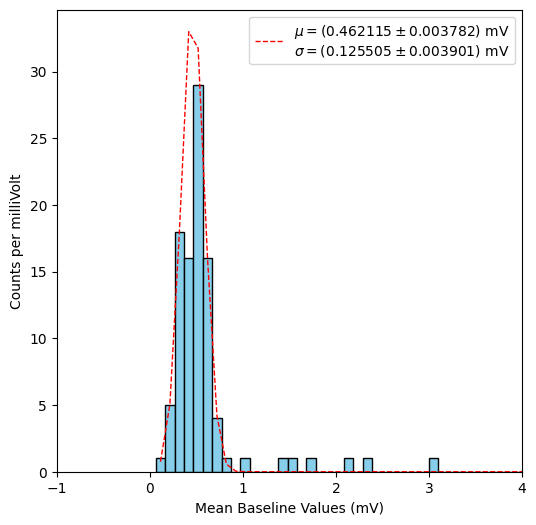

Converged after 1 iterations.


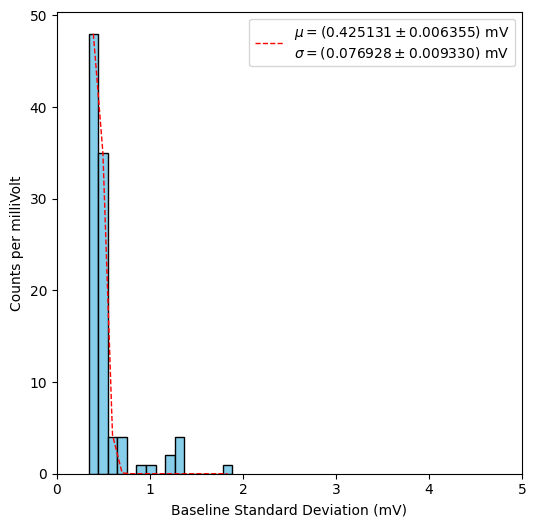

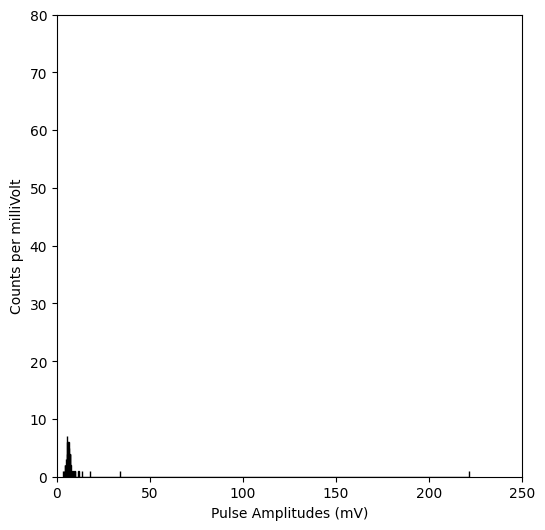

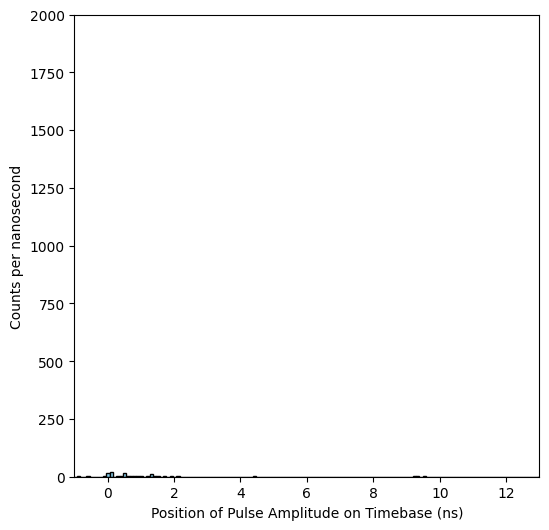

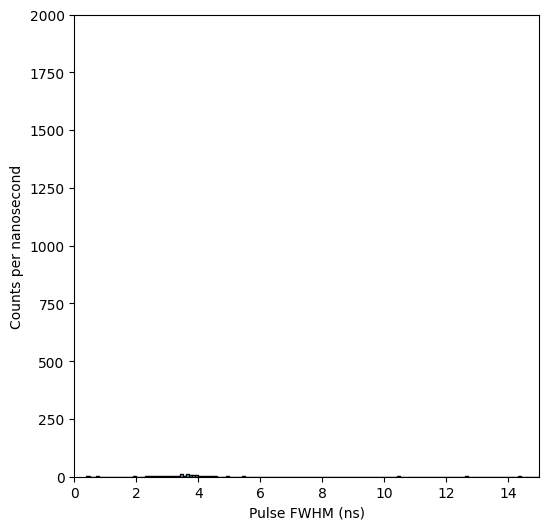

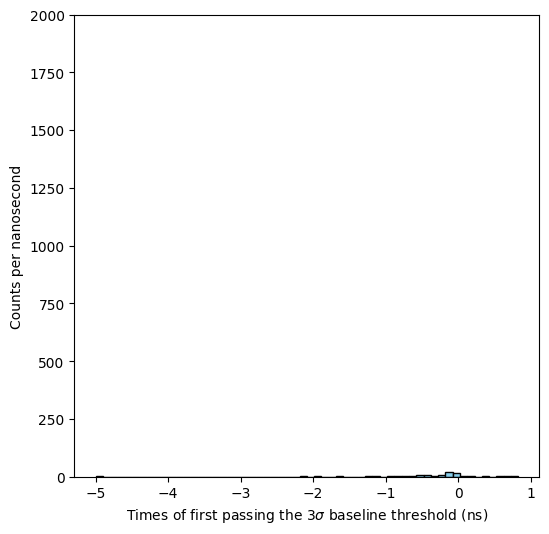

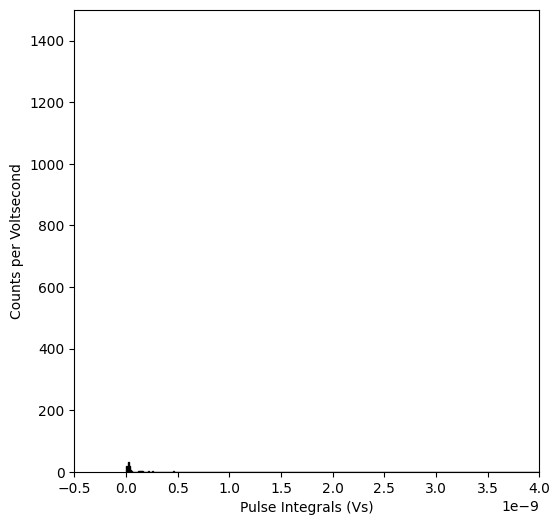

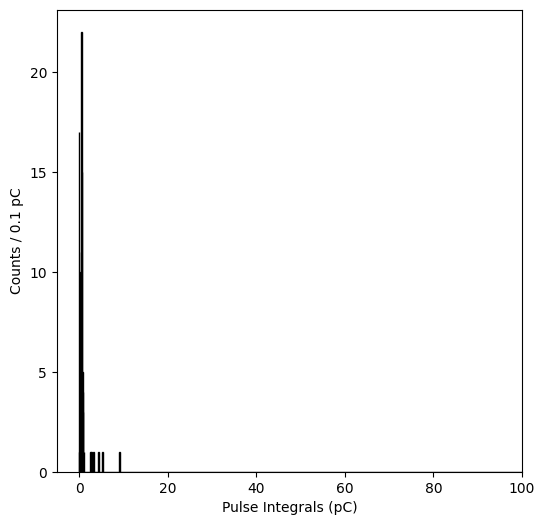

2.546375465237657 233.0408258592345


C:\Users\holly\AppData\Local\Temp\ipykernel_13756\19846943.py:283: RuntimeWarning: invalid value encountered in scalar power
  polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))


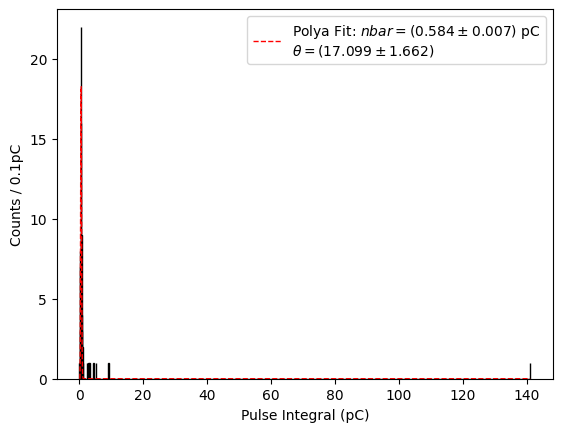

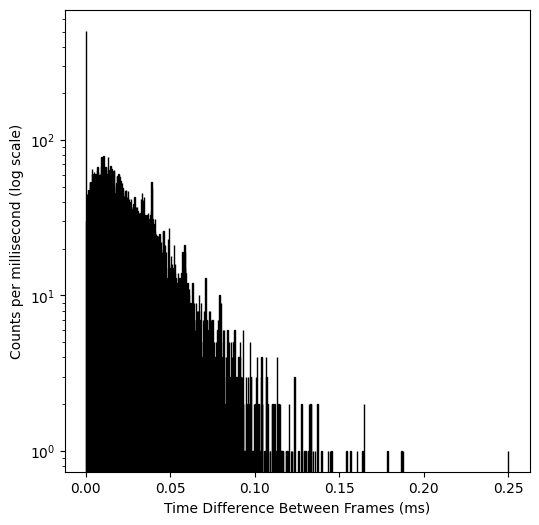

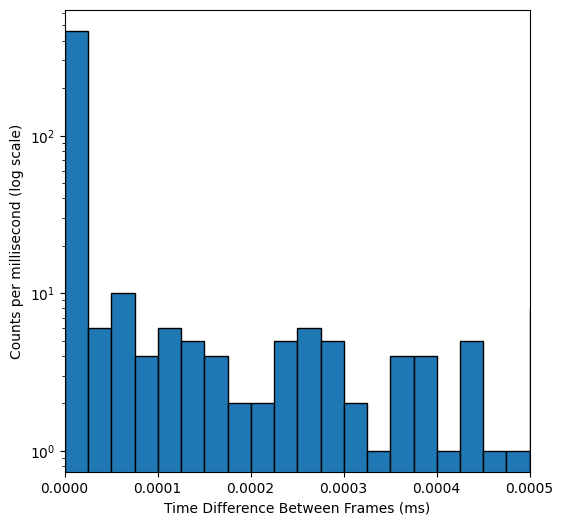

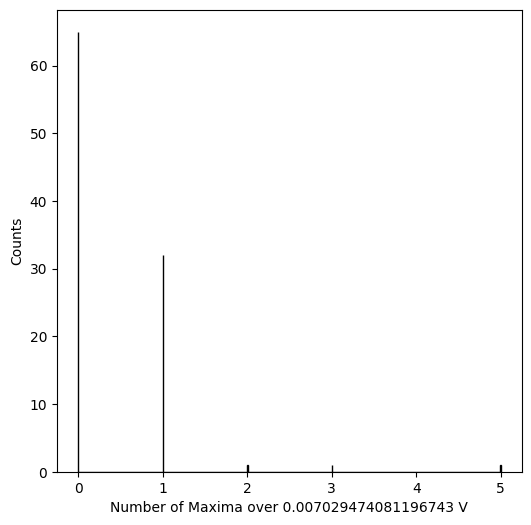

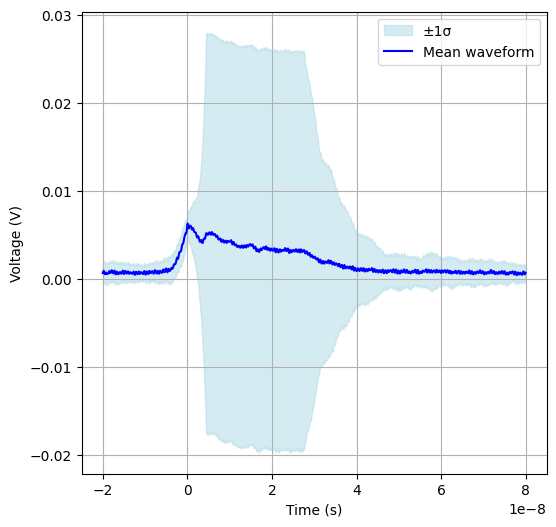

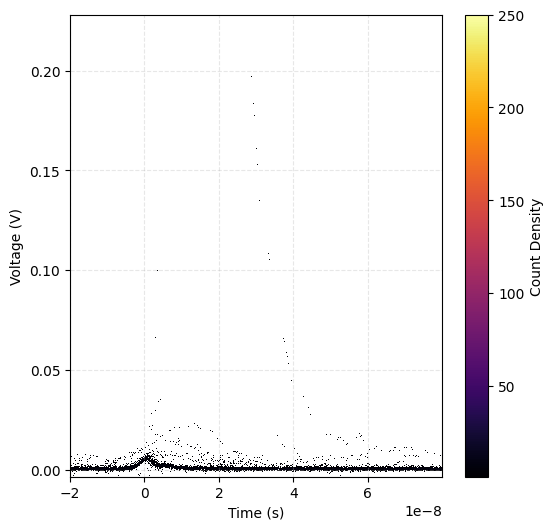

Plots complete, now making csv


"print(\n    'Mean Baseline (V):', mean_b_array,\n    'Standard Deviation of Baseline (V):', sigma_b_array,\n    'Peak Amplitudes (V):',all_amplitudes,\n    'Peak Times (s):', all_peak_times,\n    'Indices of Peaks:',all_peak_indices,\n    'FWHM of peaks:', all_FWHM,\n    't1 of FWHM:',all_t1,\n    't2 of FWHM:',all_t2,\n    'Time above 15$\\sigma$ threshold (s):', all_time_above_thresh,\n    'First crossing of 15$\\sigma$ threshold (s):', all_first_crossing,\n    'Second crossing of 15$\\sigma$ threshold (s):', all_second_crossing,\n    'Pulse Integrals:', all_integrals,\n    f'Indices of Events with Multiple Maxima over {maximum_threshold} V:', event_numbers, \n    f'Number of Peaks over Threshold:', number_of_multiple_maxima)\n"

In [ ]:

"""Making the histograms for the data"""
mean_b_array_mV = mean_b_array * 1000
sigma_b_array_mV = sigma_b_array * 1000

# histogram and gaussian for baseline mean
plt.figure(figsize=(6, 6))
def gaussian_mb(mean_b_array_mV, amp,  mu, sigma):
    gauss_mb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (mean_b_array_mV - mu)**2)/ sigma**2)
    return gauss_mb

bm_number_of_bins = int((np.max(mean_b_array_mV)-np.min(mean_b_array_mV))/0.1) #chosen 1 bin = 0.1 mV
n, bins, patches = plt.hist(mean_b_array_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

X_fit = bin_centers.copy()
Y_fit = n.copy()
p0 = [np.max(n), np.mean(bin_centers), np.std(bin_centers)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_mb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_mb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    mb_fit_full = gaussian_mb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, mb_fit_full, 'r--', linewidth=1)
    plt.xlim(-1, 4)
    plt.xlabel('Mean Baseline Values (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()



# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    gauss_sb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)
    return gauss_sb

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.1) #chosen 1 bin = 0.1mV
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=0) & (bin_centers <=2)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
# 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, sb_fit_full, 'r--', linewidth=1)
    plt.xlim(0, 5)
    plt.xlabel('Baseline Standard Deviation (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
    plt.show()

"""
# histogram and gaussian for baseline mean
plt.figure(figsize=(6, 6))
def gaussian_mb(mean_b_array_mV, amp,  mu, sigma):
    gauss_mb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (mean_b_array_mV - mu)**2)/ sigma**2)
    return gauss_mb

bm_number_of_bins = int((np.max(mean_b_array_mV)-np.min(mean_b_array_mV))/0.1) #chosen 1 bin = 0.1 mV
n, bins, patches = plt.hist(mean_b_array_mV, bins=bm_number_of_bins, color = 'skyblue', edgecolor = 'black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(gaussian_mb, bin_centers, n, p0=[np.max(n), np.mean(mean_b_array_mV), np.std(mean_b_array_mV)])
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
mb_fit = gaussian_mb(bin_centers, *popt)
plt.plot(bin_centers, mb_fit, 'r--', linewidth=1)
plt.xlim(-1, 4)
plt.xlabel('Mean Baseline Values (mV)')
plt.ylabel('Counts per milliVolt')
plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
plt.show()

# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    gauss_sb = amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)
    return gauss_sb

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.1) #chosen 1 bin = 0.1mV
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])
popt, pcov = curve_fit(gaussian_sb, bin_centers, n, p0=[np.max(n), np.mean(sigma_b_array_mV), np.std(sigma_b_array_mV)])
err_mu = np.sqrt(pcov[1,1])
err_sigma = np.sqrt(pcov[2,2])
sb_fit = gaussian_mb(bin_centers, *popt)
plt.plot(bin_centers, sb_fit, 'r--', linewidth=1)
plt.xlim(0, 5)
plt.xlabel('Baseline Standard Deviation (mV)')
plt.ylabel('Counts per milliVolt')
plt.legend([
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        popt[1], err_mu, popt[2], err_sigma)], loc='best', fontsize=10)
plt.show()
print(sb_number_of_bins)
"""
# histogram for Peak Amplitudes
plt.figure(figsize=(6, 6))
all_amplitudes_mV = all_amplitudes * 1000
amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,250)
plt.ylim(0,80)
plt.xlabel('Pulse Amplitudes (mV)')
plt.ylabel('Counts per milliVolt')
plt.show()

# histogram of Peak Times
plt.figure(figsize=(6, 6))
all_peak_times_ns = all_peak_times *1e9
pt_number_of_bins = int((np.max(all_peak_times_ns)-np.min(all_peak_times_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_peak_times_ns, bins=pt_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-1,13)
plt.ylim(0,2000)
plt.xlabel('Position of Pulse Amplitude on Timebase (ns)')
plt.ylabel('Counts per nanosecond')
plt.show()

# histogram for FWHM values
plt.figure(figsize=(6, 6))
all_FWHM_ns = all_FWHM * 1e9
fwhm_number_of_bins = int((np.max(all_FWHM_ns)-np.min(all_FWHM_ns))/0.1) #chosen 1 bin = 0.1ns
plt.hist(all_FWHM_ns, bins=fwhm_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,15)
plt.ylim(0,2000)
plt.xlabel('Pulse FWHM (ns)')
plt.ylabel('Counts per nanosecond')
plt.show()

# histogram for first crossings of 15sigma threshold
filtered_crossings = [t for t in all_first_crossing if t is not None]
if len(filtered_crossings) > 1:
    filtered_crossings_ns = np.array(filtered_crossings) * 1e9

    crosst_number_of_bins = int((np.max(filtered_crossings_ns) - np.min(filtered_crossings_ns)) / 0.1) #chosen 1 bin = 0.1ns

    plt.figure(figsize=(6, 6))
    plt.hist(filtered_crossings_ns, bins=crosst_number_of_bins, color='skyblue', edgecolor='black')
    #plt.xlim(-6,8)
    plt.ylim(0,2000)
    plt.xlabel('Times of first passing the 3$\sigma$ baseline threshold (ns)')
    plt.ylabel('Counts per nanosecond')
    plt.show()
else:
    print("Cannot plot histogram: Fewer than two valid first crossing times found.")


# histogram of pulse integrals in Vs
plt.figure(figsize=(6, 6))
int_number_of_bins = int((np.max(all_integrals)-np.min(all_integrals))/1e-11) #chosen 1 bin = 10Vps
plt.hist(all_integrals, bins=int_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-0.5e-9, 4e-9)
plt.ylim(0,1500)
plt.xlabel('Pulse Integrals (Vs)')
plt.ylabel('Counts per Voltsecond')
plt.show()

# histogram of pulse integrals in units of charge
Resistance = ((1/10000) + (1/50))**(-1)
all_integrals_picocharge = (all_integrals * 1e12) / Resistance
plt.figure(figsize=(6, 6))
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(-5, 100)
#plt.ylim(0,1500)
plt.xlabel('Pulse Integrals (pC)')
plt.ylabel('Counts / 0.1 pC')
plt.show()

# Adding polya distribution to pulse integral graph
positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]
def polya_dist(positive_charge_data, A, nbar, theta):
    # A = amplitide/normalisation factor
    polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))
    return polya_PMF

Delta_x = 0.1 
int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x)
n, bins, patches = plt.hist(positive_charge_data, bins=int_number_of_bins, color='skyblue', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

initial_nbar = np.mean(positive_charge_data)
initial_var = np.var(positive_charge_data) 
print(initial_nbar, initial_var)
N_events = len(positive_charge_data)
initial_A = N_events * Delta_x
initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

p0 = [initial_A, initial_nbar, initial_theta]

popt, pcov = curve_fit(polya_dist, bin_centers, n , p0=p0, absolute_sigma=True, maxfev=10000)
A_fit, nbar_fit, theta_fit = popt
err_A = np.sqrt(pcov[0, 0])
err_nbar = np.sqrt(pcov[1, 1])
err_theta = np.sqrt(pcov[2, 2])
polya_dist_fit = polya_dist(bin_centers, *popt)

plt.plot(bin_centers, polya_dist_fit, 'r--', linewidth=1)
plt.xlabel('Pulse Integral (pC)')
plt.ylabel('Counts / 0.1pC')
plt.legend([
   r'Polya Fit: $nbar=(%.3f \pm %.3f)\ \mathrm{pC}$'
        '\n'
        r'$\theta=(%.3f \pm %.3f)$' % (
            nbar_fit, err_nbar,
            theta_fit, err_theta)], loc='best', fontsize=10)
plt.show()

"""deadtime analysis"""
event_timestamps = np.array(tdatefrac) + np.array(tdate)

event_time_diff = np.diff(event_timestamps)

#making histogram, change number of bins later
plt.figure(figsize=(6, 6))
plt.hist(event_time_diff[:-1], bins=timediffbins, edgecolor='black')
plt.yscale('log')  # set y-axis to logarithmic scale
plt.xlabel('Time Difference Between Frames (ms)')
plt.ylabel('Counts per millisecond (log scale)')
plt.show()

#zoomed in histogram
plt.figure(figsize=(6, 6))
plt.hist(event_time_diff[:-1], bins=zoomedtimediffbins, edgecolor='black')
plt.yscale('log')  # set y-axis to logarithmic scale
plt.xlabel('Time Difference Between Frames (ms)')
plt.ylabel('Counts per millisecond (log scale)')
plt.xlim(0, zoom) # zoom into interesting range (0 to 0.5us)
plt.show()

#previous code for just a set value
event_numbers = []
number_of_multiple_maxima = []
number_of_maxima_all = []

#maximum_threshold = 0.03 #threshold for code to consider a peak a maximum in the event, eg. 30mV
min_peak_sep = 0.1*samples[0] #minimum separate between 'peaks' eg. 10% of all samples

#loop over events
for event_index, corrected_tempVolt in enumerate(corrected_tempVolts):
    count = 0  #reset counter of maxima
    prev_max_index = -min_peak_sep
    maximum_threshold = 15 * sigma_b_array[event_index]
    #loop over all voltage points in each event
    
    for i, voltage in enumerate(corrected_tempVolt):
        if voltage > maximum_threshold:
            if i - prev_max_index >= min_peak_sep:
                count += 1  #count number of times passes below threshold
                prev_max_index = i
    #add ALL event counts to all maxima array
    number_of_maxima_all.append(count)

    if count > 1: #store events with more than 1 maximum
        event_numbers.append(event_index) 
        number_of_multiple_maxima.append(count) 

event_numbers = np.array(event_numbers)
number_of_multiple_maxima = np.array(number_of_multiple_maxima)   
number_of_maxima_all = np.array(number_of_maxima_all)

#plot histogram of number of maxima
plt.figure(figsize=(6, 6))
plt.hist(number_of_maxima_all, bins=1000, edgecolor='black')
plt.xlabel(f'Number of Maxima over {maximum_threshold} V')
plt.ylabel('Counts')
plt.show()

""" Creating Average Waveform from all the data """

def average_waveform(tempVolts):
    numEvents = len(tempVolts)
    numSamples = len(tempVolts[0])
    mean_waveform = []
    std_waveform = []

    for i in range(numSamples): # loop over each time point in the waveform
        sample_values = [tempVolts[event][i] for event in range(numEvents)]  # creates a list of voltages at the same time point across all events
        mean_waveform.append(np.mean(sample_values))
        std_waveform.append(np.std(sample_values))
    return np.array(mean_waveform), np.array(std_waveform)

mean_waveform, std_waveform = average_waveform(tempVolts)

plt.figure(figsize=(6, 6))
plt.fill_between(sampleTimes,
                 mean_waveform - std_waveform,
                 mean_waveform + std_waveform,
                 color='lightblue', alpha=0.5, label='±1σ')

plt.plot(sampleTimes, mean_waveform, label='Mean waveform', color='blue')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
#plt.title('Average Waveform')
plt.legend()
plt.grid(True)
plt.show()

# creating heat map
tempVolts_array = np.array(tempVolts)
all_voltages = tempVolts_array.flatten()
num_events = tempVolts_array.shape[0]
all_times = np.tile(sampleTimes, num_events)

voltage_range = np.max(all_voltages) - np.min(all_voltages)
desired_bin_width = 0.0001
num_voltage_bins = int(voltage_range / desired_bin_width)
if num_voltage_bins < 1:
    num_voltage_bins = 1

num_time_bins = tempVolts_array.shape[1]

plt.figure(figsize=(6,6))
hist, xedges, yedges, im = plt.hist2d( all_times, all_voltages, bins=[num_time_bins, num_voltage_bins], cmap=cm.inferno, cmin=1, vmax = 250)
cbar = plt.colorbar(im)

cbar.set_label('Count Density')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
#plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

print('Plots complete, now making csv')


"""print the arrays"""

"""print(
    'Mean Baseline (V):', mean_b_array,
    'Standard Deviation of Baseline (V):', sigma_b_array,
    'Peak Amplitudes (V):',all_amplitudes,
    'Peak Times (s):', all_peak_times,
    'Indices of Peaks:',all_peak_indices,
    'FWHM of peaks:', all_FWHM,
    't1 of FWHM:',all_t1,
    't2 of FWHM:',all_t2,
    'Time above 15$\sigma$ threshold (s):', all_time_above_thresh,
    'First crossing of 15$\sigma$ threshold (s):', all_first_crossing,
    'Second crossing of 15$\sigma$ threshold (s):', all_second_crossing,
    'Pulse Integrals:', all_integrals,
    f'Indices of Events with Multiple Maxima over {maximum_threshold} V:', event_numbers, 
    f'Number of Peaks over Threshold:', number_of_multiple_maxima)
"""

#to see the bad point
#for i, t in enumerate(all_first_crossing):
 #   if t < -20e-9:
  #      print(i, t)




In [ ]:
"""export data in a csv"""

df = pd.DataFrame({
            'baseline': mean_b_array,
            'sd_baseline': sigma_b_array,
            'amplitude': all_amplitudes,
            'peak_time': all_peak_times,
            'FWHM': all_FWHM,
            't1_of_FWHM': all_t1,
            't2_of_FWHM': all_t2,
            'time_above_sigma': all_time_above_thresh,
            'first_sigma_crossing': all_first_crossing,
            'second_sigma_crossing': all_second_crossing,
            'integral_pC': all_integrals_picocharge,
            'peaks_over_15sigma_threshold': number_of_maxima_all,
            'event_timestamps' : event_timestamps[:-1]
            })


#df.to_csv(file_path, sep=',', encoding='utf-8-sig', index=False, header=True)

print('CSV done!')


ValueError: All arrays must be of the same length